# Imports

In [71]:
import re
from os import makedirs, system
from pathlib import Path
from timeit import timeit
import matplotlib as mpl
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from src import networks as nws
from src import pykwrapper as pkw
from pykinetic.writers.python import Batch as Writer
from pykinetic.classes import ConvergenceParameters, SimulationParameters, Compound
import seaborn as sns
from scipy import optimize
from scipy.stats import pearsonr
import math

pd.options.display.max_columns = 100



params = {"font.family": "Arial", 'mathtext.default': 'regular'}      
plt.rc('font', size=8)
plt.rcParams.update(params)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
nice_structure_names = {
    "00-lpdoh2": "[LPd(OH)$_2$]",
    "99-l2pd2oh4": "[LPd(OH)$_2$]$_2$",
    "01-rxt": "RXT",
    "02-ts-rxt-c1": "RXT-C1",
    "03-c1": "C1",
    "04-ts-c1-c2": "C1-C2",
    "05-c2": "C2",
    "06-c2-h2o": "C2 + H$_2$O", 
    "07-ts-c2-c3": "C2-C3",
    "08-c3-boh3": "C3 + B(OH)$_3$", 
    "09-c3": "C3",
    "10-ts-c3-c4": "C3-C4",
    "11-c4": "C4",
    "12-ts-rxt-t1": "RXT-T1",
    "13-t1": "T1",
    "14-ts-t1-t2": "T1-T2",
    "15-t2": "T2",
    "16-t2-h2o": "T2 + H$_2$O", 
    "18-t3-boh3": "T3 + B(OH)$_3$", 
    "17-ts-t2-t3": "T2-T3",
    "19-t3": "T3",
    "20-ts-t3-t4": "T3-T4",
    "21-t4": "T4",
    "22-c5": "C5",
    "23-ts-c5-c6": "C5-C6",
    "24-t5": "T5",
    "25-ts-t5-t6": "T5-T6",
    "27-ts-t2-xa": "T2-XA",
    "28-xa": "XA",
    "29-ts-xa-t3": "XA-T3",
    "30-ts-t2-xb": "T2-XB",
    "31-xb": "XB",
    "32-ts-xb-t3": "XB-T3",
    "33-ts-rxt-ya": "RXT-YA",
    "34-ya": "YA",
    "35-ts-ya-c1": "YA-C1",
    "36-ts-rxt-yb": "RXT-YB",
    "37-yb": "YB",
    "38-ts-yb-c1": "YB-C1",
    "39-t2-lig": "T2 + L",
    "40-ts-t2-p1": "T2-P1",
    "42-p1-boh3": "P1 + B(OH)$_3$",
    "42-p1": "P1",
    "43-t3-lig": "T3 + L",
    "44-ts-t3-p1": "T3-P1",
    "45-p1-h2o": "P1 + H$_2$O",
    "64-t3ob-1h2o": "T3OB + H$_2$O",
    "binaph": "BiNaph",
    "pre-catalyst-dimer": "[Pd(OH)$_2$]$_2$",
    "pre-catalyst-monomer": "[Pd(OH)$_2$]",
    "ligand": "L",
    "naphh-t": "NaphH-T",
    'naphboh2': 'NaphB(OH)$_2$',
    'h2o': "H$_2$O",
    'boh3': "B(OH)$_3$",
}

proper_names_dict = {'3q-adjohnphos': "AdJohnPhos",
 '3r-adbrettphos': "AdBrettPhos",
 '3j-brettphos': "BrettPhos",
 '3d-cyjohnphos': "CyJohnPhos",
 '3e-cymephos': "CyMePhos",
 '3f-davephos': "DavePhos",
 '3a-iprjohnphos': "(i-Pr)JohnPhos",
 '3p-me4tbuxphos': "Me$_4$tBuXPhos",
 '2k-pad3': "P(Ad)$_3$",
 '2f-pcpt3': "P(Cpt)$_3$",
 '2h-pcy2tbu': "P(Cy)$_2$(t-Bu)",
 '2g-pcy3': "P(Cy)$_3$",
 '3b-phjohnphos': "PhJohnPhos",
 '3c-phdavephos': "PhDavePhos",
 '2e-pipr3': "P(i-Pr)$_3$",
 '2d-potol3': "P(o-tol)$_3$",
 '2c-pph3': "P(Ph)$_3$",
 '2i-ptbu2cy': "P(t-Bu)$_2$(Cy)",
 '2j-ptbu3': "P(t-Bu)$_3$",
 '3h-ruphos': "RuPhos",
 '3g-sphos': "SPhos",
 '3k-tbujohnphos': "JohnPhos",
 '3o-tbubrettphos': "tBuBrettPhos",
 '3m-tbudavephos': "tBuDavePhos",
 '3l-tbumephos': "tBuMePhos",
 '3n-tbuxphos': "tBuXPhos",
 '3i-xphos': "XPhos",   
 '9c-etjohnphos': "EtJohnPhos",
 '9d-mejohnphos': "MeJohnPhos",
 '9a-cbujohnphos': 'CbuJohnPhos',
 '9b-cptjohnphos': 'CptJohnPhos',
 '9e-pcbu3': 'P(Cbu)$_3$',     
 '9f-pcpr3': 'P(Cpr)$_3$',
 '9h-pme3': 'P(Me)$_3$',
 '9g-pet3': 'P(Et)$_3$',
}

In [4]:
DEBUG: bool = True  # Debug utilities

MK_T: float = 333.15               # Temperature (K)

kb: float = 1.38064852E-023     # Boltzmann Constant (kg·m2·s-2·K-1)
Na: float = 6.02214076E+023     # Avogadro's Number (mol-1)
h: float = 6.62607004E-034      # Plank Constant (m2·kg·s-1)
R: float = 8.31445985           # Ideal Gas Constant (kg⋅m2⋅s−2⋅K−1⋅mol−1)


def calc_kd (
    mu: float                   # Viscosity Constant (kg·m-1·s-1)
    , T: float=MK_T             # Temperature (K)
    , kb: float=kb              # Boltzmann Constant (kg·m2·s-2·K-1)
    , Na: float=Na              # Avogadro's Number (mol-1)
) -> float:         
    out: float = (kb * 8 * T)  # kg·m2·s-2·K-1 · K             -> kg·m2·s-2 
    out /= (3 * mu)            # kg·m2·s-2     / kg·m-1·s-1    -> m3·s-1
    out *= Na                  # m3·s-1        · mol-1         -> m3·mol-1·s-1
    return out                 # Diffusion constant kd (m3·mol-1·s-1)

def k2ae (
    kd: float                  # Diffusion constant kd (m3·mol-1·s-1)
    , T: float=MK_T            # Temperature (K)
    , kb: float=kb             # Boltzmann Constant (kg·m2·s-2·K-1)
    , R: float=R               # Ideal Gas Constant (kg⋅m2⋅s−2⋅K−1⋅mol−1)
    , h: float=h               # Planck Constant (m2·kg·s-1)
) -> float:
    ae: float = kb*(T)/h       # kg·m2·s-2·K-1 · K / m2·kg·s-1 -> s-1
    ae = kd/ae                 # m3·mol-1·s-1 / s-1            -> m3·mol-1
    ae = np.log(ae)            # m3·mol-1 · (c⊖)1–m (mol·m-3)  -> 1
    ae *= -R*(T)               # 1 · kg⋅m2⋅s−2⋅K−1⋅mol−1 · K   -> kg⋅m2⋅s−2⋅K−1⋅mol−1 
    return (ae)                # Ae (kg⋅m2⋅s−2⋅mol−1)[J·mol-1] -> J/mol
    
def joule2hartree (
    J: float
) -> float: 
    return J / 2625.5 / 1000

calc_ae = lambda x: joule2hartree(k2ae(calc_kd(x)))

def get_mk_file(D_NAME, mk_params, concentrations_dict, barrier_change=None):
    D_PATH: Path = Path("microkinetics")                    # Data directory
    R_PATH: Path = Path("microkinetics")                 # Results directory
    D_NAME: str = D_NAME                           # Name of the dataset

    DS_DIR: Path = D_PATH/D_NAME                   # Dataset location
    RS_DIR: Path = R_PATH/D_NAME                   # Results location

    GRAPH_FILE: Path = RS_DIR/"graph.svg"          # Graph file path
    MODEL_FILE: Path = RS_DIR/f"{D_NAME}-model.py"           # MK model file path
    RESULTS_FILE: Path = RS_DIR/f"{D_NAME}-results.csv"      # Results path
    RESULTS_PLT_FILE: Path = RS_DIR/"results.png"  # Results plot path
    if DEBUG:
        SUM_PLT_FILE: Path = RS_DIR/"sum.png"      # Sum plot path
        INDEX_FILE: Path = RS_DIR/"indexfile.dat"  # Indexfile Path
    DIFF_EXP: bool = False             # Use explicit diffusion barrier value
    # If DIFF_EXP is False -> DIFF_Bar will be treated as the viscosity constant and the ae
    # for diffusion will be computed using the Eyring equation.
    DIFF_BAR: float | None = 2e-7                    
    # Diff threshold, reactions with an activation energy below this value will be considered
    # diffusion determined reactions with an activation barrier of DIFF_BAR. If set to None,
    # DIFF_THD == DIFF_BAR
    DIFF_THD: float | None = 1.6e-4 #  0.1 kcal/mol    


    MK_TFIN = mk_params['MK_TFIN']  # Simulation Time (s)
    MK_TREP = mk_params['MK_TREP']  # Simulation Log (s)
    MK_DT = mk_params['MK_DT']    # Simulation dt (s)
    ODE_RTOL: float = 1E-7   # Relative accuracy for the LSODA solver
    ODE_ATOL: float = 1E-12  # Absolute accuracy for the LSODA solver


    inters_df = pd.read_csv(DS_DIR/f"{D_NAME}-intermediates.csv")
    t_states_df = pd.read_csv(DS_DIR/f"{D_NAME}-transformations.csv")

    if D_NAME == "theoretical":
        t_states_df.loc[t_states_df['Flag'] == 'rxt-c2', 'Energy'] += barrier_change/2625.5*4.184
    elif barrier_change != None:
        for key in barrier_change.keys():
            t_states_df.loc[t_states_df['Flag'] == key, 'Energy'] += barrier_change[key]/2625.5*4.184


    makedirs(RS_DIR, exist_ok=True)

    inters = {r["structure"]: nws.Intermediate(code=r["structure"], energy=r["qh-G(T)_SPC"]) for _, r in inters_df.iterrows()}
    filter_nan = lambda xs: tuple([inters[a] for a in xs if not pd.isna(a)])
    get_ts_dict = lambda x: {
        "components": (filter_nan(x[0:2]), filter_nan(x[2:4]))
        , "energy": x["Energy"]
        , "backwards": x["Backwards"]
    }
    t_states = [nws.TransitionState(**get_ts_dict(ts)) for i, ts in t_states_df.iterrows()]
    org_net = nws.OrganicNetwork.from_dict({"intermediates": inters, "ts": t_states})

    diffusion = None
    if DIFF_BAR is not None: 
        if not DIFF_EXP: DIFF_BAR = calc_ae(DIFF_BAR)
        if not DIFF_THD: DIFF_THD = DIFF_BAR
        diffusion = (DIFF_BAR, DIFF_THD) 
        print(
            "Diffusion barrier set to: {:.6f} hartrees, with threshold {:.6f} hartrees"
            .format(DIFF_BAR, DIFF_THD)
        )

    cs = pkw.nws_to_cs(org_net, temp=MK_T, diffusion=diffusion, unit='hartree')

    if DEBUG:
        from pykinetic.utils import write_indexfile
        write_indexfile(cs, INDEX_FILE, isrelative=True)

    initial_concentrations = {cs.compounds.index(Compound(reagent, '')): concentration 
                              for reagent, concentration in concentrations_dict.items()}


    simulation = SimulationParameters(
        concentrations=initial_concentrations
        , tfin=MK_TFIN
        , trep=MK_TREP
        , dt=MK_DT
    )
    convergence = ConvergenceParameters(rtol=ODE_RTOL,atol=ODE_ATOL)

    writer = Writer()
    writer.set_parameters(simulation=simulation, convergence=convergence)
    writer.parameters["out_filename"] = RESULTS_FILE
    writer.write(cs, filepath=MODEL_FILE)
    timeit(
    lambda: system(f"python {MODEL_FILE}")
    , number=1
    )
    
    header = ("time",) + tuple((c.label for c in cs.compounds))
    df = pd.read_csv(
        RESULTS_FILE
        , delimiter="\t"
        , header=None
        , names = header
    )

    return cs, df

def get_mk_profile(D_NAME, cs, df, concentrations_dict, desired_traces, plot=True):
    R_PATH: Path = Path("microkinetics")                 # Results directory
    D_NAME: str = D_NAME                           # Name of the dataset

    RS_DIR: Path = R_PATH/D_NAME                   # Results location
    RESULTS_PLT_FILE: Path = RS_DIR/f"{D_NAME}-results.png"  # Results plot path

    # Normalizing the concentrations
    for col in df.columns[1:]:
        df[col] = df[col]/(concentrations_dict['naphboh2'])

    if plot == True:
        selected_cpds = {}
        for structure in desired_traces.keys():
            for cpd in cs.compounds:
                if cpd.label == structure:
                    selected_cpds[cpd] = {'label': nice_structure_names[cpd.label], 'color': desired_traces[structure]}

        if 'pre-catalyst-dimer' in concentrations_dict.keys():
            selected_cpds.pop(Compound('00-lpdoh2', ''), None)
            selected_cpds.pop(Compound('99-l2pd2oh4', ''), None)

        plt.rcParams['figure.dpi'] = 180
        plt.rcParams['figure.figsize'] = (4,4)

        fig, ax = plt.subplots()

        for compound, cpd_dict in selected_cpds.items():
            ax.plot(df["time"], df[compound.label], label=cpd_dict['label'], color=cpd_dict['color'])

        plt.legend(fontsize=6)
        plt.xlabel('reaction time / s')
        plt.ylabel('relative population')

        ax.spines[['right', 'top']].set_visible(False)           
        plt.tick_params(bottom=False) 

        ligand_name = re.sub(r'^[^-]*-', '', D_NAME)

        plt.title(f'L = {proper_names_dict[ligand_name]}')
        plt.savefig(RESULTS_PLT_FILE)
    
    return df['naphh-t'].iloc[-1]

def check_convergence(df, column):
    return abs((df[column].iloc[-1])-(df[column].iloc[-2]))

def get_microkinetic_durations(mk_params_df, ligand):
    return mk_params_df.loc[mk_params_df['microkinetic_name'] == ligand][['MK_TFIN', 'MK_TREP', 'MK_DT']].to_dict('records')[0]

def get_microkinetic_yields(D_NAME, desired_yields):
    D_PATH: Path = Path("microkinetics")                    # Data directory
    R_PATH: Path = Path("microkinetics")                 # Results directory
    D_NAME: str = D_NAME                           # Name of the dataset

    DS_DIR: Path = D_PATH/D_NAME                   # Dataset location
    RS_DIR: Path = R_PATH/D_NAME                   # Results location

    RESULTS_FILE: Path = RS_DIR/f"{D_NAME}-results.csv"      # Results path

    inters_df = pd.read_csv(DS_DIR/f"{D_NAME}-intermediates.csv")
    t_states_df = pd.read_csv(DS_DIR/f"{D_NAME}-transformations.csv")

    inters = {r["structure"]: nws.Intermediate(code=r["structure"], energy=r["qh-G(T)_SPC"]) for _, r in inters_df.iterrows()}
    filter_nan = lambda xs: tuple([inters[a] for a in xs if not pd.isna(a)])
    get_ts_dict = lambda x: {
        "components": (filter_nan(x[0:2]), filter_nan(x[2:4]))
        , "energy": x["Energy"]
        , "backwards": x["Backwards"]
    }
    t_states = [nws.TransitionState(**get_ts_dict(ts)) for i, ts in t_states_df.iterrows()]
    org_net = nws.OrganicNetwork.from_dict({"intermediates": inters, "ts": t_states})


    cs = pkw.nws_to_cs(org_net, temp=MK_T, diffusion=None, unit='hartree')

    header = ("time",) + tuple((c.label for c in cs.compounds))
    df = pd.read_csv(
        RESULTS_FILE
        , delimiter="\t"
        , header=None
        , names = header
    )
    naphboh2_conc = df['naphboh2'].iloc[0]
    # Normalizing the concentrations
    for col in df.columns[1:]:
        df[col] = df[col]/(naphboh2_conc)

    yield_dict = {}

    for cpd in desired_yields:
        for compound in cs.compounds:
            if compound.label == cpd:
                yield_dict[cpd] = df[compound.label].iloc[-1]

    return yield_dict




## Auto-generation of microkinetic duration parameters

In [70]:
threshold = 1e-08
auto_generate = False
plot_mk = True
repopulate_yields = False
if auto_generate:
    mk_params_df = pd.read_csv("autotuned_microkinetic_parameters.csv")
    trial_list = []
    for _, row in mk_params_df.iterrows():
        converged = False
        trial_mk_params = {'MK_TFIN': 1E+1 if row['min_of_max_barrier'] <= 16.0 else 1E+4}
        trial_mk_params['MK_TREP'] = trial_mk_params['MK_TFIN']/1E+3
        trial_mk_params['MK_DT'] = trial_mk_params['MK_TFIN']/1E+4
        counter = 0
        while not converged:
            D_NAME = row['microkinetic_name']
            if row['microkinetic_type'] == 'p1':
                concentrations_dict = {'naphboh2': 0.02, 'pre-catalyst-dimer': 0.001, 'h2o': 0.07, 'ligand': 0.002} # units are in M 
            else:
                concentrations_dict = {'naphboh2': 0.02, '99-l2pd2oh4': 0.001, 'h2o': 0.07} # units are in M 
            cs, df = get_mk_file(D_NAME=D_NAME, mk_params=trial_mk_params, concentrations_dict=concentrations_dict)
            convergent_species = ['00-lpdoh2', 'naphh-t', '05-c2', '15-t2', '19-t3']
            if all([check_convergence(df, species) < threshold for species in convergent_species]):
                converged = True
                trial_mk_params['microkinetic_name'] = D_NAME
                trial_mk_params['comp_yield_3.5'] = get_mk_profile(D_NAME=D_NAME, cs=cs, df=df, concentrations_dict=concentrations_dict, desired_traces="", plot=False)
                trial_list.append(trial_mk_params)
            elif counter == 8:
                converged = True
                print(f"{D_NAME} did not converge!")
            else:
                counter += 1
                for key in trial_mk_params.keys():
                    trial_mk_params[key] = trial_mk_params[key]*1E+1
    mk_params_df = pd.merge(mk_params_df, pd.DataFrame(trial_list), on='microkinetic_name', how='left')
    mk_params_df.to_csv("autotuned_microkinetic_parameters.csv", index=False)
else:
    try:
        mk_params_df = pd.read_csv("autotuned_microkinetic_parameters.csv")
        if plot_mk:
            cmap = mpl.cm.get_cmap('tab10')
            desired_traces = {'00-lpdoh2': cmap.colors[2],
                        'pre-catalyst-dimer': cmap.colors[2],
                        '05-c2': "#C04A1B",
                        '15-t2': cmap.colors[4],
                        '19-t3': cmap.colors[6], 
                        'naphboh2': "black", 
                        'naphh-t': "#204195",
                        '31-xb': 'purple',
                        '42-p1': 'lightseagreen',
                        '64-t3ob-1h2o': '#b65a85',
                        'binaph': 'darkgreen',
                        }
            yield_dict = {}
            for _, row in mk_params_df[mk_params_df['microkinetic_name'] == 'p1-3a-iprjohnphos'].iterrows():
            #for _, row in mk_params_df.iterrows():
                D_NAME = row['microkinetic_name']
                print(D_NAME)
                if row['microkinetic_type'] == 'p1':
                    concentrations_dict = {'naphboh2': 0.02, 'pre-catalyst-dimer': 0.001, 'h2o': 0.07, 'ligand': 0.002} # units are in M 
                else:
                    concentrations_dict = {'naphboh2': 0.02, '99-l2pd2oh4': 0.001, 'h2o': 0.07} # units are in M 
                cs, df = get_mk_file(D_NAME=D_NAME, mk_params=get_microkinetic_durations(mk_params_df, D_NAME), concentrations_dict=concentrations_dict)
                comp_yield = get_mk_profile(D_NAME=D_NAME, cs=cs, df=df, concentrations_dict=concentrations_dict, desired_traces=desired_traces, plot=True)
                plt.close()
                yield_dict[D_NAME] = comp_yield
            if repopulate_yields:
                mk_params_df['comp_yield_3.5'] = mk_params_df['microkinetic_name'].map(yield_dict)
                mk_params_df.to_csv("autotuned_microkinetic_parameters.csv", index=False)
    except FileNotFoundError:
        print("Microkinetic parameters missing! Use autotuner")

/tmp/ipykernel_2117/3431786238.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('tab10')


p1-3a-iprjohnphos
Diffusion barrier set to: 0.005524 hartrees, with threshold 0.000160 hartrees

          nfev=10848
          njev=633
          nlu=633
          status=0
          success=True
          


## Get Yields of Interest

In [6]:
p1_ligands = mk_params_df[mk_params_df['microkinetic_type'] == 'p1']['ligand_name'].unique()
p1_main_params_df = mk_params_df[mk_params_df['ligand_name'].isin(p1_ligands)].copy()

overall_dict = {}

for name in p1_ligands:
    overall_dict[name] = {}
    main_dict = get_microkinetic_yields(f"main-{name}", ['05-c2', 'naphh-t'])
    for key, value in main_dict.items():
        overall_dict[name][f"main-{key}"] = value  
    p1_dict = get_microkinetic_yields(f"p1-{name}", ['05-c2', '42-p1', 'naphh-t'])
    for key, value in p1_dict.items():
        overall_dict[name][f"p1-{key}"] = value

p1_yield_df = pd.DataFrame(overall_dict).T
# Multiply all values by 100
p1_yield_df = p1_yield_df*100
p1_yield_df

,main-05-c2,main-naphh-t,p1-05-c2,p1-42-p1,p1-naphh-t
2c-pph3,9.989665,6.493522,3.503446,3.244584e+00,0.000002
2e-pipr3,9.790833,5.043049,4.728537,2.577178e+00,2.142436
2f-pcpt3,9.945840,1.956658,6.188022,1.890543e+00,0.282589
2g-pcy3,9.953638,0.351144,5.065803,2.465192e+00,0.002491
3a-iprjohnphos,1.007452,98.992460,1.004227,6.216453e-01,98.374039
3d-cyjohnphos,9.991313,30.944021,2.007417,3.992295e+00,2.866179
3k-tbujohnphos,6.429841,93.569984,6.417722,6.666848e-13,93.582103
9a-cbujohnphos,0.430948,99.569052,0.060708,4.969646e+00,13.971387
9b-cptjohnphos,5.198498,94.800838,1.193232,4.402929e+00,20.535110
9c-etjohnphos,6.152851,93.832149,0.162162,4.913814e+00,0.040768


In [69]:
get_microkinetic_yields("p1-3a-iprjohnphos", ['00-lpdoh2', 'naphboh2', '05-c2', '42-p1', '70-c2dim', 'binaph', 'naphh-t', '99-l2pd2oh4'])

{'00-lpdoh2': 5.000032770514965e-07,
 'naphboh2': 0.8294675452413726,
 '05-c2': 0.011775435261603934,
 '42-p1': 0.04375835520281669,
 'naphh-t': 0.11485634780767424,
 '99-l2pd2oh4': 5.000065541230914e-15}

## Stitch Images

In [8]:
from PIL import Image
import numpy as np

def resize_images_to_same_height(images, target_height):
    resized_images = []
    for img in images:
        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(target_height * aspect_ratio)
        resized_img = img.resize((new_width, target_height), Image.LANCZOS)
        resized_images.append(resized_img)
    return resized_images

def stitch_images_horizontally(images):
    # Find the target height (minimum height of all images)
    target_height = min(img.height for img in images)

    # Resize images to the target height
    resized_images = resize_images_to_same_height(images, target_height)
    
    # Calculate the total width of the final stitched image
    total_width = sum(img.width for img in resized_images)

    # Create a new image with the appropriate size
    stitched_image = Image.new('RGB', (total_width, target_height))

    # Paste each image into the stitched image
    current_x = 0
    for img in resized_images:
        stitched_image.paste(img, (current_x, 0))
        current_x += img.width

    return stitched_image

In [73]:
stitch = True
if stitch:
    for name in mk_params_df['microkinetic_name']:
        list_im = [f'microkinetics/{name}/{name}-plot.png', f'microkinetics/{name}/{name}-results.png']
        imgs    = [ Image.open(i) for i in list_im ]
        stitch_images_horizontally(imgs).save(f'microkinetics/{name}/{name}-merged.png')
        
    for name in ['main-2g-pcy3', 'main-3d-cyjohnphos']:
        list_im = [f'microkinetics/{name}/{name}-plot-btpp.png', f'microkinetics/{name}/{name}-results-btpp.png']
        imgs    = [ Image.open(i) for i in list_im ]
        stitch_images_horizontally(imgs).save(f'microkinetics/{name}/{name}-merged-btpp.png')

    for name in mk_params_df[mk_params_df['microkinetic_type'] == 'p1']['ligand_name'].unique():
        list_im = [f'microkinetics/p1-{name}/p1-{name}-plot.png', f'microkinetics/main-{name}/main-{name}-results.png', f'microkinetics/p1-{name}/p1-{name}-results.png']
        imgs    = [ Image.open(i) for i in list_im ]
        stitch_images_horizontally(imgs).save(f'microkinetics/p1-{name}/p1-{name}-comparativemerged.png')

# Get Yield Errors

In [10]:
def get_second_order_barrier_correction(concentration, temperature):
    return math.log(1/concentration)*temperature*8.314/1000/4.184

def get_barrier_for_target_yield(barrier_change, equiv, target):
    concentrations_dict = {'naphboh2': 0.02, '99-l2pd2oh4': 0.001} # units are in M 
    concentrations_dict['h2o'] = concentrations_dict['naphboh2']*equiv
    cs, df = get_mk_file(D_NAME='theoretical', mk_params={'MK_TFIN': 1E+7, 'MK_TREP': 1E+4, 'MK_DT': 1E+3}, concentrations_dict=concentrations_dict, barrier_change=barrier_change)
    comp_yield = get_mk_profile(D_NAME='theoretical', cs=cs, df=df, concentrations_dict=concentrations_dict, desired_traces="", plot=False)
    return comp_yield-target


In [11]:
obtain_ddg_curves = False

if obtain_ddg_curves:
    target_yields = target_yields = np.concatenate((np.linspace(0.005, 0.10, 20), np.linspace(0.11, 0.19, 9), np.linspace(0.20, 0.80, 13), np.linspace(0.81, 0.90, 10), np.linspace(0.905, 0.995, 19)))
    target_equivalents = [1, 3.5, 5]

    trial_list = []
    for equivalents in target_equivalents:
        correction = get_second_order_barrier_correction(concentration=0.02*equivalents, temperature=333.15)
        for target in target_yields:
            res = optimize.root(get_barrier_for_target_yield, x0=[2.0], args=(equivalents, target))
            ddG = res['x'][0]
            yield_minus = get_barrier_for_target_yield(ddG-1.0, equiv=equivalents, target=0)
            yield_plus = get_barrier_for_target_yield(ddG+1.0, equiv=equivalents, target=0)
            corrected_ddG = ddG - correction
            trial_ddG_params = {"equivalents": equivalents, "comp_yield": target, "ddG": ddG, "comp_yield_minus": yield_minus, "comp_yield_plus": yield_plus, 
                                "corrected_ddG": corrected_ddG, "corrected_ddG_minus": corrected_ddG-1, "corrected_ddG_plus": corrected_ddG+1,}
            trial_list.append(trial_ddG_params)
            

    ddg_df = pd.DataFrame(trial_list)
    ddg_df['nice_comp_yield'] = ddg_df['comp_yield']*100
    ddg_df['nice_comp_yield_plus'] = ddg_df['comp_yield_plus']*100
    ddg_df['nice_comp_yield_minus'] = ddg_df['comp_yield_minus']*100
    ddg_df.to_csv("ddg_curves.csv", index=False)
else:
    try:
        ddg_df = pd.read_csv("ddg_curves.csv")
    except FileNotFoundError:
        print("Obtain ddg curves! Approx 45 minutes")
        

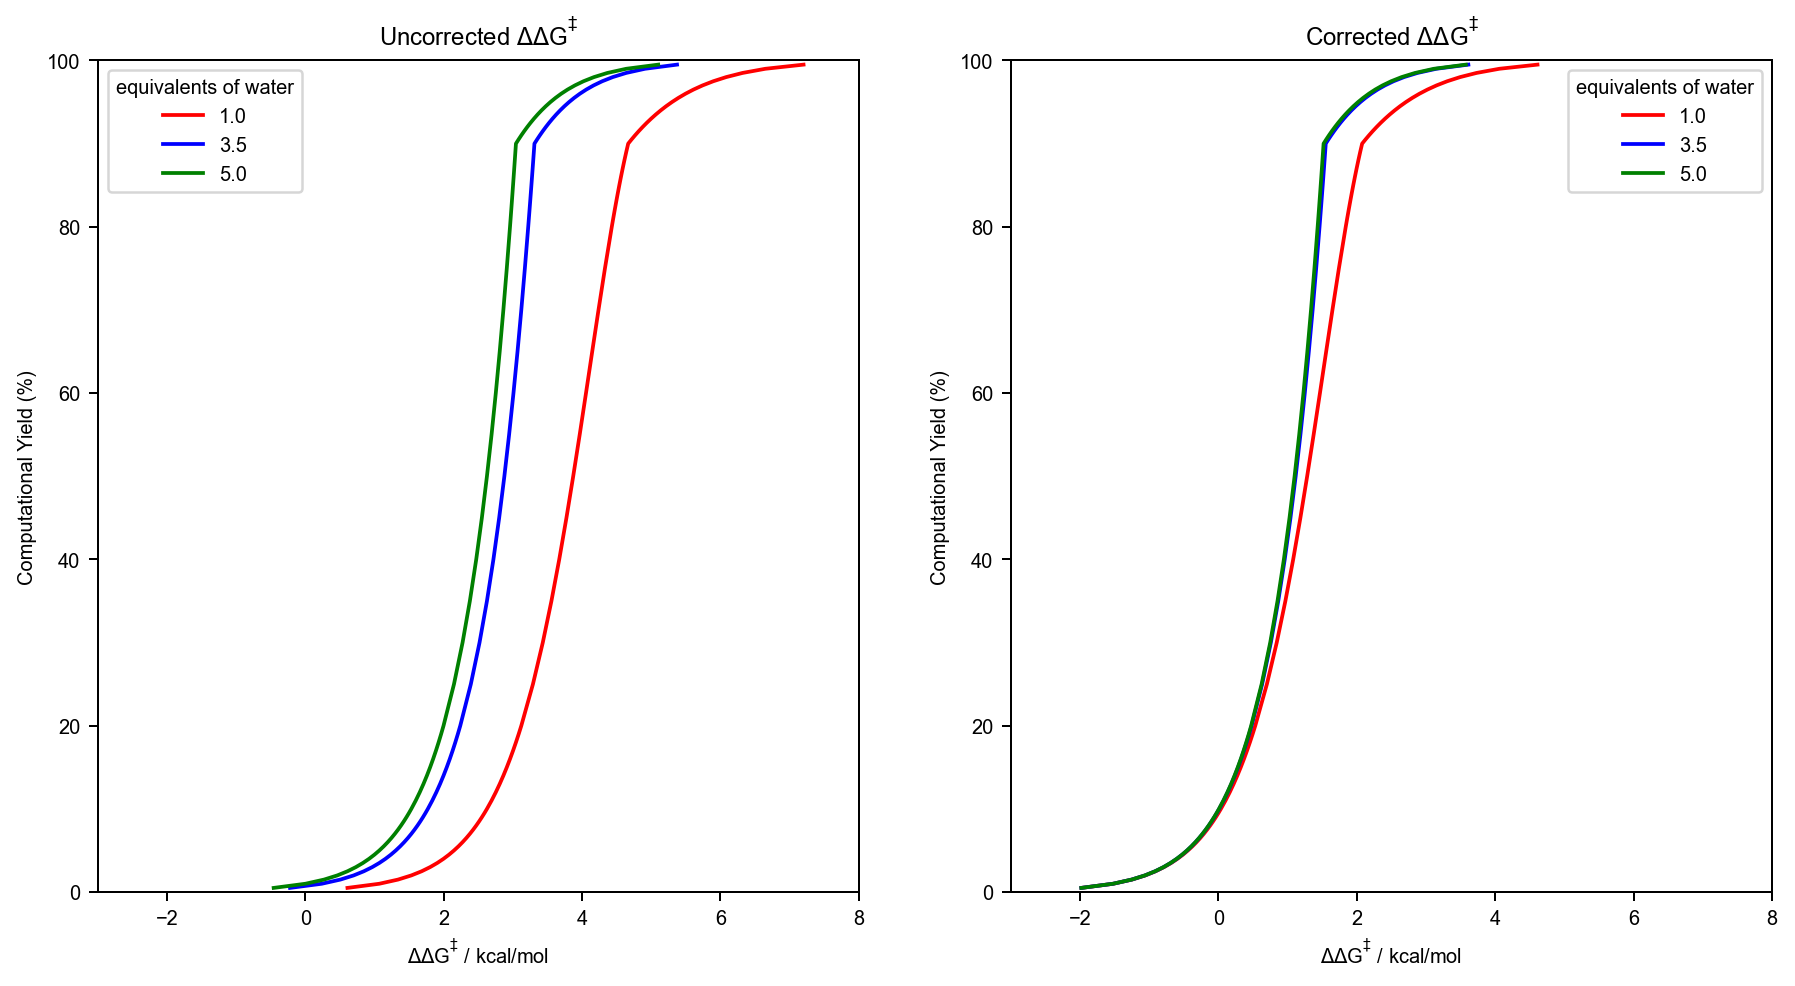

In [12]:
fig, ax = plt.subplots(1,2, figsize=(12,6), dpi=180)

ddg_df['nice_yield'] = ddg_df['comp_yield']*100

g1 = sns.lineplot(x="ddG", y="nice_yield", ax=ax[0], data=ddg_df[ddg_df['equivalents'] == 1.0], label="1.0", color='r')
g2 = sns.lineplot(x="ddG", y="nice_yield", ax=ax[0], data=ddg_df[ddg_df['equivalents'] == 3.5], label="3.5", color='b')
g3 = sns.lineplot(x="ddG", y="nice_yield", ax=ax[0], data=ddg_df[ddg_df['equivalents'] == 5.0], label="5.0", color='g')

g1 = sns.lineplot(x="corrected_ddG", y="nice_yield", ax=ax[1], data=ddg_df[ddg_df['equivalents'] == 1.0], label="1.0", color='r')
g2 = sns.lineplot(x="corrected_ddG", y="nice_yield", ax=ax[1], data=ddg_df[ddg_df['equivalents'] == 3.5], label="3.5", color='b')
g3 = sns.lineplot(x="corrected_ddG", y="nice_yield", ax=ax[1], data=ddg_df[ddg_df['equivalents'] == 5.0], label="5.0", color='g')

for axis in ax:
    axis.set_ylim([-0,100])
    axis.set_xlim([-3,8])
    axis.set_ylabel("Computational Yield (%)")
    axis.set_xlabel("$\Delta\Delta G^{\u2021}$ / kcal/mol")
    axis.legend(title="equivalents of water")

ax[0].set_title("Uncorrected $\Delta\Delta G^{\u2021}$")    
ax[1].set_title("Corrected $\Delta\Delta G^{\u2021}$")

plt.savefig('ddg.png', transparent=True, bbox_inches="tight")

## Get Yield Spreads from Water

In [13]:
water_tuning = True

if water_tuning:
    water_equivalents = [1.0, 5.0]
    water_yields = {}
    for _, row in mk_params_df.iterrows():
        D_NAME = row['microkinetic_name']
        water_yields[D_NAME] = {}
        for equivalents in water_equivalents:
            if row['microkinetic_type'] == 'p1':
                concentrations_dict = {'naphboh2': 0.02, 'pre-catalyst-dimer': 0.001, 'ligand': 0.002} # units are in M 
            else:
                concentrations_dict = {'naphboh2': 0.02, '99-l2pd2oh4': 0.001} # units are in M 
            concentrations_dict['h2o'] = concentrations_dict['naphboh2']*equivalents
            cs, df = get_mk_file(D_NAME=D_NAME, mk_params=get_microkinetic_durations(mk_params_df, D_NAME), concentrations_dict=concentrations_dict)
            comp_yield = get_mk_profile(D_NAME=D_NAME, cs=cs, df=df, concentrations_dict=concentrations_dict, desired_traces="", plot=False)
            water_yields[D_NAME].update({f"comp_yield_{equivalents}": comp_yield})

    water_df = pd.DataFrame(water_yields)
    water_df = water_df.T.reset_index()
    water_df.rename(columns={'index': 'microkinetic_name'}, inplace=True)
    mk_params_df = mk_params_df.merge(water_df, on='microkinetic_name', how='left')
    mk_params_df.to_csv("autotuned_microkinetic_parameters.csv", index=False)
else:
    try:
        _ = mk_params_df['comp_yield_1.0']
    except KeyError:
        print("Water yield spreads does not exist! Run water tuning")
        

Diffusion barrier set to: 0.005524 hartrees, with threshold 0.000160 hartrees

          nfev=11231
          njev=682
          nlu=682
          status=0
          success=True
          
Diffusion barrier set to: 0.005524 hartrees, with threshold 0.000160 hartrees

          nfev=11252
          njev=646
          nlu=646
          status=0
          success=True
          
Diffusion barrier set to: 0.005524 hartrees, with threshold 0.000160 hartrees

          nfev=11095
          njev=591
          nlu=591
          status=0
          success=True
          
Diffusion barrier set to: 0.005524 hartrees, with threshold 0.000160 hartrees

          nfev=11148
          njev=693
          nlu=693
          status=0
          success=True
          
Diffusion barrier set to: 0.005524 hartrees, with threshold 0.000160 hartrees

          nfev=10693
          njev=550
          nlu=550
          status=0
          success=True
          
Diffusion barrier set to: 0.005524 hartrees, with 

## Barrier Tuning To Parity

In [14]:
def get_barrier_tuning_to_parity_yield(barrier_change, ligand, equiv, target, plot_mk=False):
    concentrations_dict = {'naphboh2': 0.02, '00-lpdoh2': 0.002} # units are in M 
    concentrations_dict['h2o'] = concentrations_dict['naphboh2']*equiv
    barrier_change_dict = {}
    for ts in ['02-ts-rxt-c1', '04-ts-c1-c2', '33-ts-rxt-ya', '35-ts-ya-c1', '36-ts-rxt-yb', '38-ts-yb-c1']:
        barrier_change_dict[ts] = barrier_change   
    for ts in ['13-t1', '15-t2', '17-ts-t2-t3', '20-ts-t3-t4', '27-ts-t2-xa', '29-ts-xa-t3', '30-ts-t2-xb', '32-ts-xb-t3', '40-ts-t2-p1']:      
        barrier_change_dict[ts] = -barrier_change

    mk_params = get_microkinetic_durations(mk_params_df, ligand)
    for key in mk_params.keys():
        mk_params[key] = mk_params[key]*1E+0 # ensure convergence
        
    cs, df = get_mk_file(D_NAME=ligand, mk_params=mk_params, concentrations_dict=concentrations_dict, barrier_change=barrier_change_dict)
    if plot_mk:
        cmap = mpl.cm.get_cmap('tab10')
        desired_traces = {'00-lpdoh2': cmap.colors[2],
                    'pre-catalyst': cmap.colors[2],
                    '05-c2': "#C04A1B",
                    '15-t2': cmap.colors[4],
                    '19-t3': cmap.colors[6], 
                    'naphboh2': "black", 
                    'naphh-t': "#204195",
                    '31-xb': 'purple',
                    '42-p1': 'lightseagreen'}
        comp_yield = get_mk_profile(D_NAME=ligand, cs=cs, df=df, concentrations_dict=concentrations_dict, desired_traces=desired_traces, plot=True)
    else:
        comp_yield = get_mk_profile(D_NAME=ligand, cs=cs, df=df, concentrations_dict=concentrations_dict, desired_traces="", plot=False)
    return comp_yield-target


In [15]:
barrier_tuning = False

if barrier_tuning:
    barrier_tuning_dict = {}
    # Only tune for main
    main_df = mk_params_df.loc[mk_params_df['microkinetic_type'] == 'main']
    for _, row in mk_params_df.iterrows():
        ligand = row['microkinetic_name']
        target = row['exp_yield']
        equiv = 3.5
        if math.isnan(target):
            barrier_tuning_dict[ligand] = np.nan
        else:
            # Barrier tuning for some ligands needs a different starting x0 (like -1.0) to prevent divergence
            res = optimize.root(get_barrier_tuning_to_parity_yield, x0=[0.0], args=(ligand, equiv, target, False))
            barrier_tuning_dict[ligand] = res['x'][0]
    mk_params_df['barrier_tuning_to_parity'] = mk_params_df['microkinetic_name'].map(barrier_tuning_dict)
    mk_params_df.to_csv("autotuned_microkinetic_parameters.csv", index=False)
else:
    try:
        barrier_tuning = mk_params_df['barrier_tuning_to_parity']
    except KeyError:
        print("Barrier tuning to parity does not exist! Run barrier tuning")

## Merge all dataframes

In [19]:
dataframe_merge = True

if dataframe_merge:
    barrier_df = pd.read_csv("all_barriers.csv")
    barrier_df.rename(columns={"group": "ligand_name"}, inplace=True)
    barrier_df['exp_name'] = barrier_df.apply(lambda row: row['ligand_name'].split('-')[0], axis=1)
    mk_params_df = pd.read_csv("autotuned_microkinetic_parameters.csv")
    mk_pivoted_df = mk_params_df.pivot(index='ligand_name', columns='microkinetic_type', 
                    values=['comp_yield_1.0', 'comp_yield_3.5', 'comp_yield_5.0', 'barrier_tuning_to_parity'])
    mk_pivoted_df.columns = [f'{col[0]}_{col[1]}' for col in mk_pivoted_df.columns]
    mk_pivoted_df = mk_pivoted_df.reset_index()
    barrier_df = barrier_df.merge(mk_pivoted_df)
    barrier_df['prediction_quality'] = barrier_df.apply(lambda row: "Good" if abs(row['barrier_tuning_to_parity_main']) <= 1.0 else "Poor", axis=1)

    kraken_df = pd.read_csv("kraken_descriptors.csv")

    barrier_df = barrier_df.merge(kraken_df, left_on="ligand_name", right_on="name")
    barrier_df.drop(columns=["name"], inplace=True)
    barrier_df.to_csv("full_processed_data.csv", index=False)
    nice_yields_list = ['exp_yield', 'exp_error']
    for equiv in [1.0, 3.5, 5.0]:
        for mk_type in ['hc', 'main', 'ob', 'p1', 'pd3oac6', 'xa', 'yayb']:
            nice_yields_list.append(f'comp_yield_{equiv}_{mk_type}')
    for col in nice_yields_list:
        barrier_df[f"nice_{col}"] = barrier_df[col]*100

    for mk_type in ['hc', 'main', 'ob', 'p1', 'pd3oac6', 'xa', 'yayb']:
        barrier_df[f'nice_comp_yield_3.5_{mk_type}_minus'] = barrier_df[f'nice_comp_yield_3.5_{mk_type}'] - barrier_df[f'nice_comp_yield_1.0_{mk_type}']
        barrier_df[f'nice_comp_yield_3.5_{mk_type}_plus'] = barrier_df[f'nice_comp_yield_5.0_{mk_type}'] - barrier_df[f'nice_comp_yield_3.5_{mk_type}']
else:
    try:
        barrier_df = pd.read_csv("full_processed_data.csv")
        nice_yields_list = ['exp_yield', 'exp_error']
        for equiv in [1.0, 3.5, 5.0]:
            for mk_type in ['hc', 'main', 'ob', 'p1', 'pd3oac6', 'xa', 'yayb']:
                nice_yields_list.append(f'comp_yield_{equiv}_{mk_type}')
        for col in nice_yields_list:
            barrier_df[f"nice_{col}"] = barrier_df[col]*100

        for mk_type in ['hc', 'main', 'ob', 'p1', 'pd3oac6', 'xa', 'yayb']:
            barrier_df[f'nice_comp_yield_3.5_{mk_type}_minus'] = barrier_df[f'nice_comp_yield_3.5_{mk_type}'] - barrier_df[f'nice_comp_yield_1.0_{mk_type}']
            barrier_df[f'nice_comp_yield_3.5_{mk_type}_plus'] = barrier_df[f'nice_comp_yield_5.0_{mk_type}'] - barrier_df[f'nice_comp_yield_3.5_{mk_type}']

    except FileNotFoundError:
        print("Merge dataframes!")

## Figure S56

/tmp/ipykernel_2117/3581780029.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['< -1.5', '-1.0', '-0.5', '0.0', '0.5', '1.0', '> 1.5'])  # vertically oriented colorbar


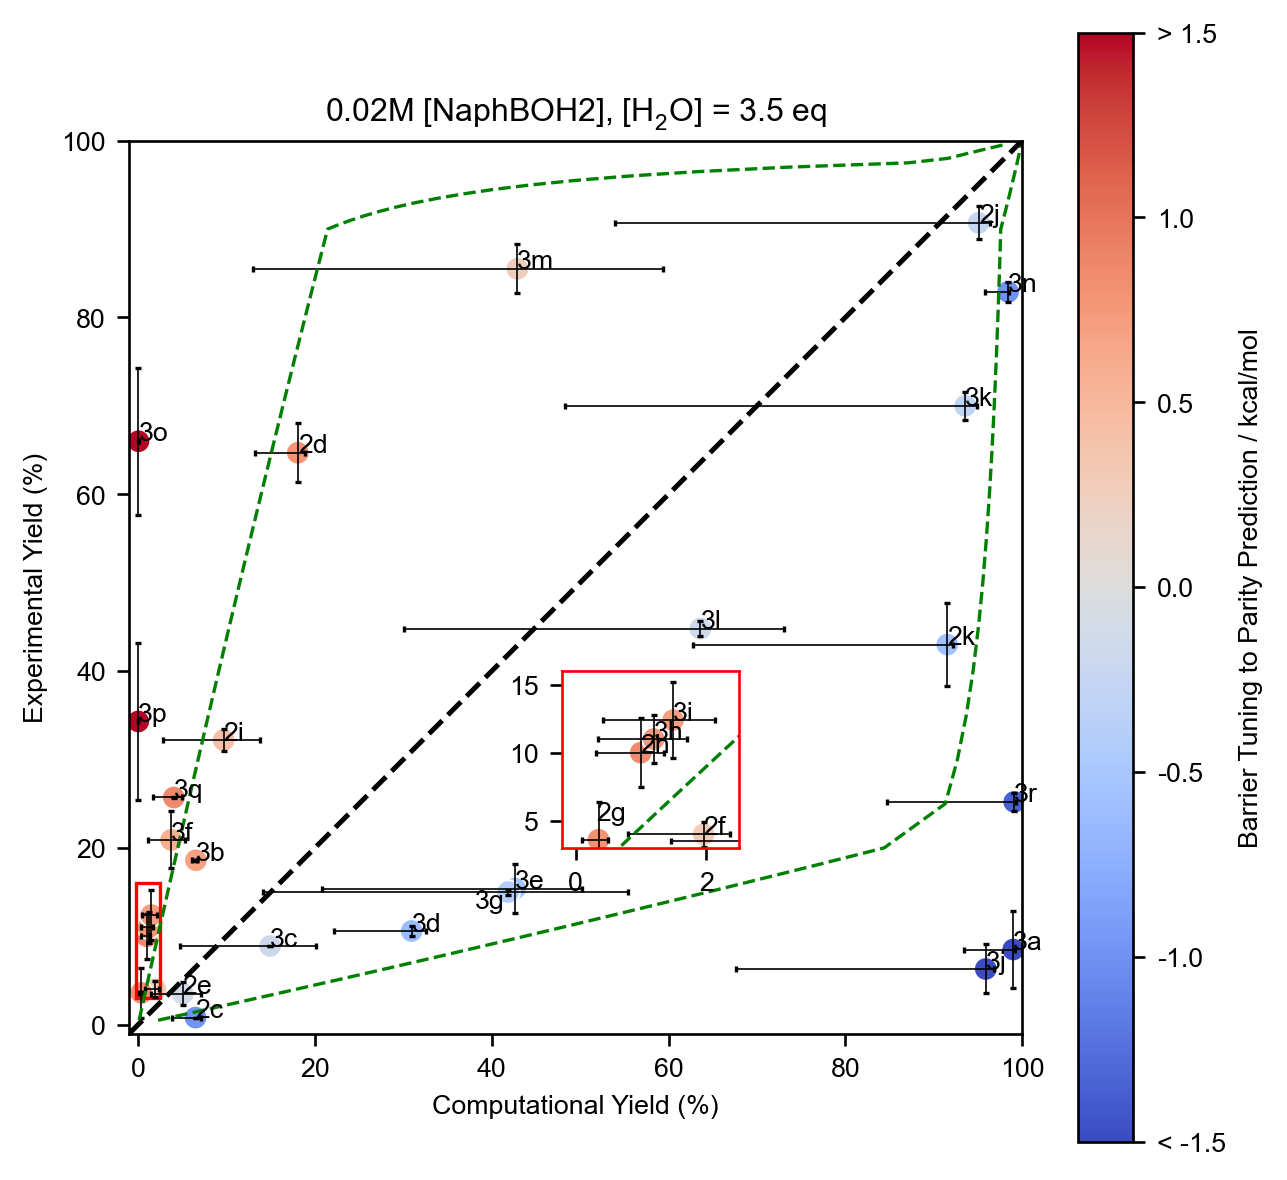

In [23]:
cmap = plt.get_cmap('coolwarm')
norm = mpl.colors.Normalize(vmin=-1.5, vmax=1.5,clip=False)

main_df = barrier_df[~barrier_df['ligand_name'].str.contains('9')].copy()
ddg_10 = ddg_df[ddg_df['equivalents'] == 1.0].copy()
ddg_35 = ddg_df[ddg_df['equivalents'] == 3.5].copy()
ddg_50 = ddg_df[ddg_df['equivalents'] == 5.0].copy()
    
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=240)

g4 = sns.scatterplot(x='nice_comp_yield_3.5_main', y='nice_exp_yield', ax=ax, data=main_df, s=50,
                    hue_norm=norm, hue='barrier_tuning_to_parity_main', palette='coolwarm',
                    )
g5 = plt.errorbar(x='nice_comp_yield_3.5_main', y='nice_exp_yield', 
                    xerr=(main_df['nice_comp_yield_3.5_main_minus'], main_df['nice_comp_yield_3.5_main_plus']), 
                    yerr='nice_exp_error', 
                    data=main_df, fmt='none', ecolor='black', capsize=1, linewidth=0.5)

g2 = sns.lineplot(x="nice_comp_yield_minus", y="nice_comp_yield", ax=ax, data=ddg_50, 
                    color='g', linestyle='--', linewidth=1)
g3 = sns.lineplot(x="nice_comp_yield_plus", y="nice_comp_yield", ax=ax, data=ddg_50, 
                    color='g', linestyle='--', linewidth=1)


ax.set_aspect('equal')
ax.set_xlim([-1,100])
ax.set_ylim([-1,100])


for _, row in main_df[(main_df['nice_exp_yield'] >= 16) | (main_df['nice_comp_yield_3.5_main'] >= 2)].iterrows():
    if row['exp_name'] == '3g':
        ax.text(row['nice_comp_yield_3.5_main']*0.91, row['nice_exp_yield']*0.88, row['exp_name'], fontsize=8)
    else:
        ax.text(row['nice_comp_yield_3.5_main']*1.0001, row['nice_exp_yield']*1.001, row['exp_name'], fontsize=8)

ax.axline((-10,-10), slope=1, linestyle='--', c='black')
ax.set_xlabel("Computational Yield (%)")
ax.set_ylabel("Experimental Yield (%)")

ax.set_title("0.02M [NaphBOH2], [H$_2$O] = 3.5 eq")
ax.get_legend().remove()

x_inset1_start = -0.2
x_inset1_end = 2.5
y_inset1_start = 3
y_inset1_end = 16

rect1 = mpl.patches.Rectangle((x_inset1_start, y_inset1_start), x_inset1_end-x_inset1_start, y_inset1_end-y_inset1_start, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect1)
    
axin1 = ax.inset_axes([48, 20, 20, 20], transform=ax.transData)
#axin1 = ax.inset_axes([20, 47, 25, 30], transform=ax.transData)
g6 = sns.scatterplot(x='nice_comp_yield_3.5_main', y='nice_exp_yield', ax=axin1, data=main_df, s=50, 
                     hue_norm=norm, hue='barrier_tuning_to_parity_main', palette='coolwarm',
                    )
g7 = axin1.errorbar(x='nice_comp_yield_3.5_main', y='nice_exp_yield', 
                      xerr=(main_df['nice_comp_yield_3.5_main_minus'], main_df['nice_comp_yield_3.5_main_plus']), 
                      yerr='nice_exp_error', 
                      data=main_df, fmt='none', ecolor='black', capsize=1, linewidth=0.5)

g2 = sns.lineplot(x="nice_comp_yield_minus", y="nice_comp_yield", ax=axin1, data=ddg_50, 
                    color='g', linestyle='--', linewidth=1)
g3 = sns.lineplot(x="nice_comp_yield_plus", y="nice_comp_yield", ax=axin1, data=ddg_50, 
                    color='g', linestyle='--', linewidth=1)
axin1.get_legend().remove()
axin1.set_xlim([x_inset1_start,x_inset1_end])
axin1.set_ylim([y_inset1_start,y_inset1_end])
axin1.set_xlabel("")
axin1.set_ylabel("")

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                              label='barrier_tuning_to_parity_main', ax=ax)

cbar.ax.set_yticklabels(['< -1.5', '-1.0', '-0.5', '0.0', '0.5', '1.0', '> 1.5'])  # vertically oriented colorbar

cbar.ax.set_ylabel('Barrier Tuning to Parity Prediction / kcal/mol', )

for _, row in main_df[(main_df['nice_exp_yield'] <= 16) & (main_df['nice_comp_yield_3.5_main'] <= 2)].iterrows():
    if row['exp_name'] == '2g':
        axin1.text(row['nice_comp_yield_3.5_main']*0.91, row['nice_exp_yield']*1.401, row['exp_name'], fontsize=8)
    elif row['exp_name'] == '2e':
        axin1.text(row['nice_comp_yield_3.5_main']*1.0001, row['nice_exp_yield']*1.001, row['exp_name'], fontsize=8)
    else:
        axin1.text(row['nice_comp_yield_3.5_main']*1.0001, row['nice_exp_yield']*1.001, row['exp_name'], fontsize=8)

        
for spine in axin1.spines.values():
    spine.set_edgecolor('red')

plt.savefig('figure_s56.png', transparent=False, bbox_inches="tight")



## Figure 3

In [24]:
main_barrier_df = barrier_df[~barrier_df['ligand_name'].str.contains('9')].copy()

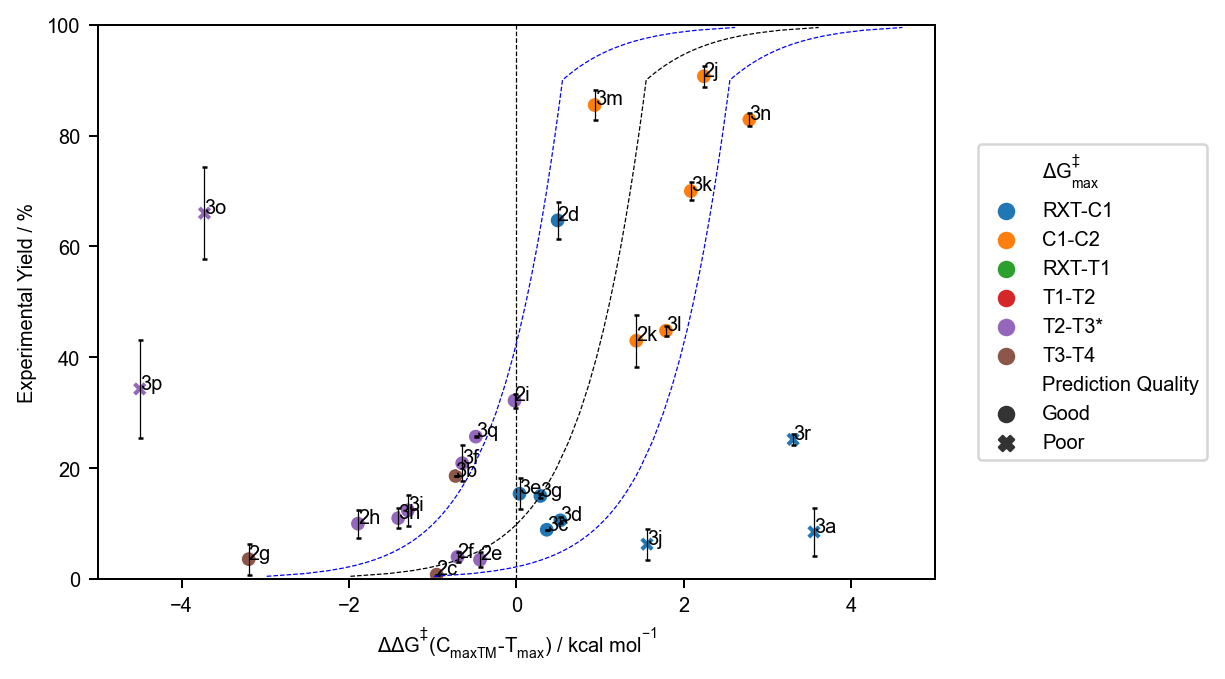

In [25]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=180)
hue_order = ['02-ts-rxt-c1', '04-ts-c1-c2', '12-ts-rxt-t1', '14-ts-t1-t2', '17-ts-t2-t3-corr_3.5', '20-ts-t3-t4']
equiv = 3.5

x = f'ddG_corr_{equiv}'
y = 'nice_exp_yield'
g = sns.scatterplot(x=x, y=y, data=main_barrier_df, hue_order=hue_order, hue=f'max_overall_corr_{equiv}_name', palette='tab10', style=main_barrier_df['prediction_quality'], ax=ax)
g5 = plt.errorbar(x=x, y=y, yerr='nice_exp_error', data=main_barrier_df, fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
for _, row in main_barrier_df.iterrows():
    ax.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8,)

ax.set_xlabel('$\Delta\Delta$G$^{\u2021}$(C$_{maxTM}$-T$_{max}$) / kcal mol$^{-1}$')
ax.set_ylabel('Experimental Yield / %')
ax.axvline(0, linestyle='--', color='black', linewidth=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([0, 100])
handles, labels = plt.gca().get_legend_handles_labels()

g = sns.lineplot(x='corrected_ddG', y='nice_yield', data=ddg_df[ddg_df['equivalents']==equiv], c='black', ax=ax, linewidth=0.5, linestyle='--')
g = sns.lineplot(x='corrected_ddG_plus', y='nice_yield', data=ddg_df[ddg_df['equivalents']==equiv], c='b', ax=ax, linewidth=0.5, linestyle='--')
g = sns.lineplot(x='corrected_ddG_minus', y='nice_yield', data=ddg_df[ddg_df['equivalents']==equiv], c='b', ax=ax, linewidth=0.5, linestyle='--')


handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,4,5,6,7,8,9]
text_list = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.04,0.5), loc="center left").get_texts()
text_list[0].set_text("$\Delta$G$^{\u2021}_{max}$")
text_list[1].set_text('RXT-C1')
text_list[2].set_text('C1-C2')
text_list[3].set_text('RXT-T1')
text_list[4].set_text('T1-T2')
text_list[5].set_text('T2-T3*')
text_list[6].set_text('T3-T4')
text_list[7].set_text('Prediction Quality')

plt.savefig('expvsmaxtc.png', transparent=True, bbox_inches="tight")


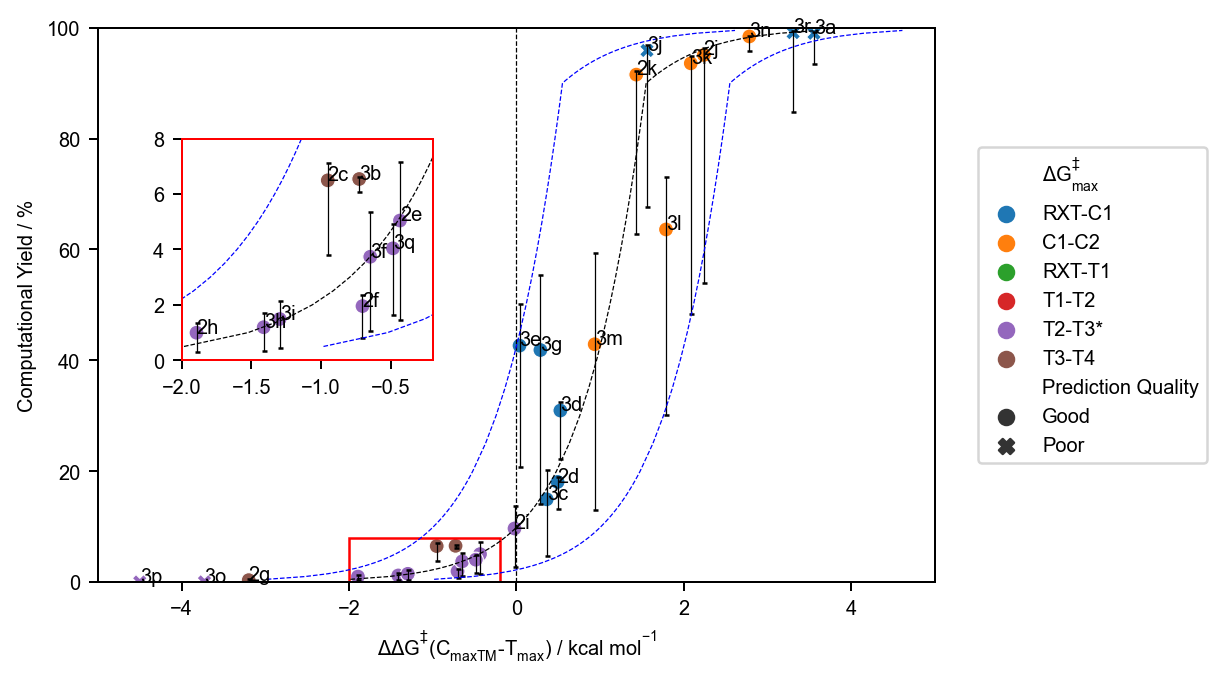

In [26]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=180)
equiv = 3.5
hue_order = ['02-ts-rxt-c1', '04-ts-c1-c2', '12-ts-rxt-t1', '14-ts-t1-t2', f'17-ts-t2-t3-corr_{equiv}', '20-ts-t3-t4']

x = f'ddG_corr_{equiv}'
y = f'nice_comp_yield_{equiv}_main'
g = sns.scatterplot(x=x, y=y, data=main_barrier_df, hue_order=hue_order, hue=f'max_overall_corr_{equiv}_name', palette='tab10', style=main_barrier_df['prediction_quality'], ax=ax)

g5 = plt.errorbar(x=x, y=y, yerr=(main_barrier_df[f'nice_comp_yield_{equiv}_main_minus'], main_barrier_df[f'nice_comp_yield_{equiv}_main_plus']), data=main_barrier_df, 
                  fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')

ax.set_xlabel('$\Delta\Delta$G$^{\u2021}$(C$_{maxTM}$-T$_{max}$) / kcal mol$^{-1}$')
ax.set_ylabel('Computational Yield / %')
ax.axvline(0, linestyle='--', color='black', linewidth=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([0, 100])
handles, labels = plt.gca().get_legend_handles_labels()

g = sns.lineplot(x='corrected_ddG', y='nice_yield', data=ddg_df[ddg_df['equivalents']==equiv], c='black', ax=ax, linewidth=0.5, linestyle='--')
g = sns.lineplot(x='corrected_ddG_plus', y='nice_yield', data=ddg_df[ddg_df['equivalents']==equiv], c='b', ax=ax, linewidth=0.5, linestyle='--')
g = sns.lineplot(x='corrected_ddG_minus', y='nice_yield', data=ddg_df[ddg_df['equivalents']==equiv], c='b', ax=ax, linewidth=0.5, linestyle='--')


x_inset1_start = -2
x_inset1_end = -0.2
y_inset1_start = 0
y_inset1_end = 8

rect1 = mpl.patches.Rectangle((x_inset1_start, y_inset1_start), x_inset1_end-x_inset1_start, y_inset1_end-y_inset1_start, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect1)
    
axin1 = ax.inset_axes([-4, 40, 3, 40], transform=ax.transData)
g = sns.scatterplot(x=x, y=y, data=main_barrier_df, hue_order=hue_order, hue=f'max_overall_corr_{equiv}_name', palette='tab10', style=main_barrier_df['prediction_quality'], ax=axin1)
g5 = axin1.errorbar(x=x, y=y, yerr=(main_barrier_df[f'nice_comp_yield_{equiv}_main_minus'], main_barrier_df[f'nice_comp_yield_{equiv}_main_plus']), data=main_barrier_df, 
                  fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')


g = sns.lineplot(x='corrected_ddG', y='nice_yield', data=ddg_df[ddg_df['equivalents']==equiv], c='black', ax=axin1, linewidth=0.5, linestyle='--')
g = sns.lineplot(x='corrected_ddG_plus', y='nice_yield', data=ddg_df[ddg_df['equivalents']==equiv], c='b', ax=axin1, linewidth=0.5, linestyle='--')
g = sns.lineplot(x='corrected_ddG_minus', y='nice_yield', data=ddg_df[ddg_df['equivalents']==equiv], c='b', ax=axin1, linewidth=0.5, linestyle='--')

axin1.get_legend().set_visible(False)
axin1.set_xlim([x_inset1_start,x_inset1_end])
axin1.set_ylim([y_inset1_start,y_inset1_end])
axin1.set_xlabel("")
axin1.set_ylabel("")

inset_1_list = ['2h', '3h', '3i', '2c', '3b', '2e', '2f', '3q', '3f']
for _, row in main_barrier_df.iterrows():
    if row['exp_name'] in inset_1_list:
        axin1.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)  
    else:
        ax.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
text_list = plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title="$\Delta$G$_{max}$").get_texts()

for spine in axin1.spines.values():
    spine.set_edgecolor('r')

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,4,5,6,7,8,9]
text_list = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.04,0.5), loc="center left").get_texts()
text_list[0].set_text("$\Delta$G$^{\u2021}_{max}$")
text_list[1].set_text('RXT-C1')
text_list[2].set_text('C1-C2')
text_list[3].set_text('RXT-T1')
text_list[4].set_text('T1-T2')
text_list[5].set_text('T2-T3*')
text_list[6].set_text('T3-T4')
text_list[7].set_text('Prediction Quality')

plt.savefig('compvsmaxtc.png', transparent=True, bbox_inches="tight")


## Kraken plots

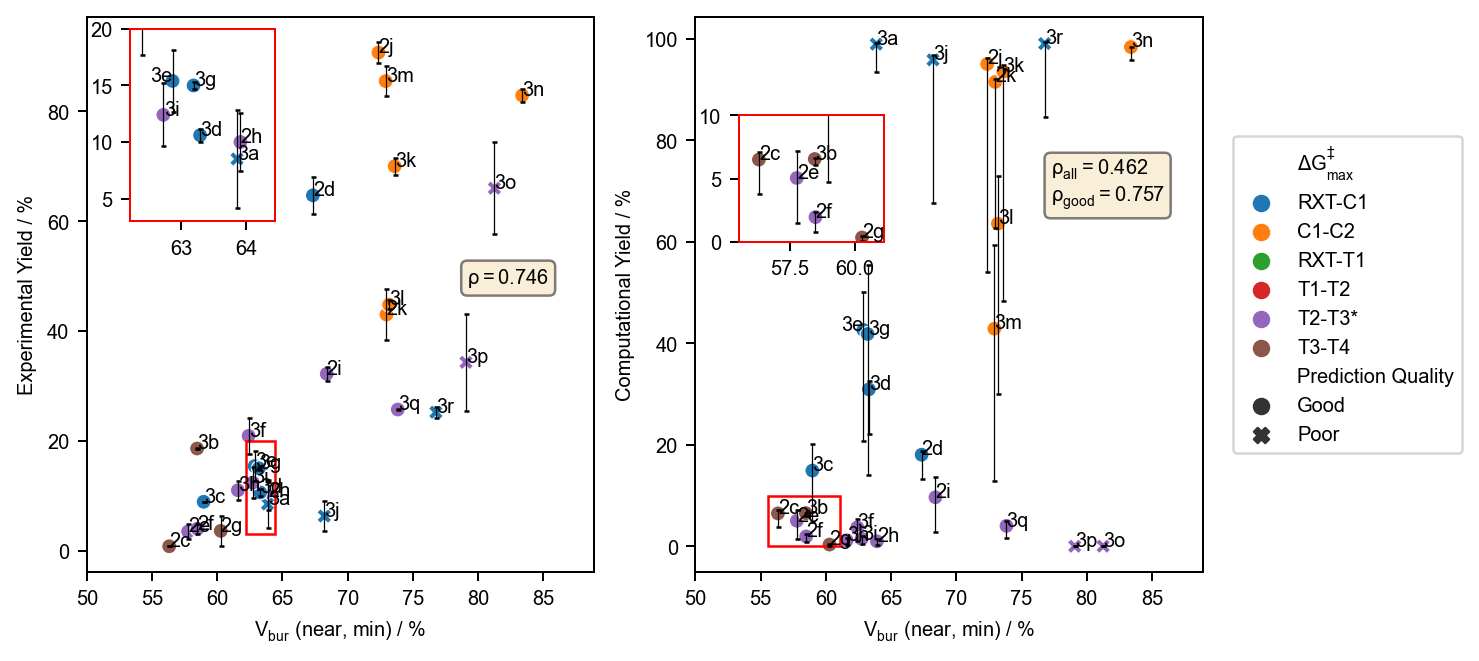

In [27]:
main_barrier_df['vbur_near_vbur_min_percent'] = main_barrier_df['vbur_near_vbur_min']/0.9

equiv = 3.5
hue_order = ['02-ts-rxt-c1', '04-ts-c1-c2', '12-ts-rxt-t1', '14-ts-t1-t2', f'17-ts-t2-t3-corr_{equiv}', '20-ts-t3-t4']

fig, ax = plt.subplots(1,2, figsize=(8,4), dpi=180)
x = 'vbur_near_vbur_min_percent'
y = 'nice_exp_yield'
g = sns.scatterplot(x=x, y=y, data=main_barrier_df, hue_order=hue_order, palette='tab10', hue=f'max_overall_corr_{equiv}_name',  style=main_barrier_df['prediction_quality'], ax=ax[0])
g5 = ax[0].errorbar(x=x, y=y, yerr='nice_exp_error', data=main_barrier_df, fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')

for _, row in main_barrier_df.iterrows():
    ax[0].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)

ax[0].get_legend().set_visible(False)
ax[0].set_xlim([45/0.9,80/0.9])

x_inset1_start = 56/0.9
x_inset1_end = 58/0.9
y_inset1_start = 3
y_inset1_end = 20

rect1 = mpl.patches.Rectangle((x_inset1_start, y_inset1_start), x_inset1_end-x_inset1_start, y_inset1_end-y_inset1_start, linewidth=1, edgecolor='r', facecolor='none')
ax[0].add_patch(rect1)

axin1 = ax[0].inset_axes([48/0.9, 60, 10/0.9, 35], transform=ax[0].transData)
g_axin1 = sns.scatterplot(x=x, y=y, data=main_barrier_df, hue_order=hue_order, palette='tab10',style=main_barrier_df['prediction_quality'], hue=f'max_overall_corr_{equiv}_name', ax=axin1)
g5 = axin1.errorbar(x=x, y=y, yerr='nice_exp_error', data=main_barrier_df, fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
axin1.get_legend().set_visible(False)
axin1.set_xlim([x_inset1_start,x_inset1_end])
axin1.set_ylim([y_inset1_start,y_inset1_end])


for _, row in main_barrier_df.iterrows():
    if (axin1.get_xlim()[0] <= row[x] < axin1.get_xlim()[1]) & (axin1.get_ylim()[0] <= row[y] < axin1.get_ylim()[1]):
        if row['exp_name'] != '3e':
            axin1.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
        else:
            axin1.text(row[x]*0.9999, row[y]*1.001, row['exp_name'], fontsize=8, ha='right')

ax[0].set_xlabel("V$_{bur}$ (near, min) / %")
ax[0].set_ylabel("Experimental Yield / %")
axin1.set_xlabel("")
axin1.set_ylabel("")

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[0].text(0.75, 0.55, r'$\rho=%.3f$' % (pearsonr(main_barrier_df[y], main_barrier_df[x])[0]),
           transform=ax[0].transAxes, verticalalignment='top', bbox=props)

x = 'vbur_near_vbur_min_percent'
y = f'nice_comp_yield_{equiv}_main'
g2 = sns.scatterplot(x=x, y=y, data=main_barrier_df, palette='tab10',hue_order=hue_order, hue=f'max_overall_corr_{equiv}_name', style=main_barrier_df['prediction_quality'], ax=ax[1])
g5 = ax[1].errorbar(x=x, y=y, yerr=(main_barrier_df[f'nice_comp_yield_{equiv}_main_minus'], main_barrier_df[f'nice_comp_yield_{equiv}_main_plus']), data=main_barrier_df, 
                  fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')

for _, row in main_barrier_df.iterrows():
    if row['exp_name'] != '3e':
        ax[1].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
    else:
        ax[1].text(row[x]*0.9999, row[y]*1.001, row['exp_name'], fontsize=8, ha='right')

        
ax[1].set_xlim([45/0.9,80/0.9])


x_inset2_start = 50/0.9
x_inset2_end = 55/0.9
y_inset2_start = 0
y_inset2_end = 10

rect2 = mpl.patches.Rectangle((x_inset2_start, y_inset2_start), x_inset2_end-x_inset2_start, y_inset2_end-y_inset2_start, linewidth=1, edgecolor='r', facecolor='none')
ax[1].add_patch(rect2)
        
axin2 = ax[1].inset_axes([48/0.9, 60, 10/0.9, 25], transform=ax[1].transData)
g_axin2 = sns.scatterplot(x=x, y=y, data=main_barrier_df, hue_order=hue_order, palette='tab10',style=main_barrier_df['prediction_quality'], hue=f'max_overall_corr_{equiv}_name', ax=axin2)
g5 = axin2.errorbar(x=x, y=y, yerr=(main_barrier_df[f'nice_comp_yield_{equiv}_main_minus'], main_barrier_df[f'nice_comp_yield_{equiv}_main_plus']), data=main_barrier_df, 
                  fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
axin2.get_legend().set_visible(False)
axin2.set_xlim([x_inset2_start,x_inset2_end])
axin2.set_ylim([y_inset2_start,y_inset2_end])

for _, row in main_barrier_df.iterrows():
    if (axin2.get_xlim()[0] <= row[x] < axin2.get_xlim()[1]) & (axin2.get_ylim()[0] <= row[y] < axin2.get_ylim()[1]):
        if row['exp_name'] != '3e':
            axin2.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8, ha='left')
        else:
            axin2.text(row[x]*0.9999, row[y]*1.001, row['exp_name'], fontsize=8, ha='right')

ax[1].set_xlabel("V$_{bur}$ (near, min) / %")
ax[1].set_ylabel("Computational Yield / %")
axin2.set_xlabel("")
axin2.set_ylabel("")

all_r = pearsonr(main_barrier_df[x], main_barrier_df[y])[0]
di = main_barrier_df[main_barrier_df['prediction_quality'] == 'Good']
good_r = pearsonr(di[x], di[y])[0]
#dg = ff[ff['vbur_near_vbur_min_percent'] <= 75]
dh = main_barrier_df[main_barrier_df['prediction_quality'] == 'Good']
some_r = pearsonr(dh[x], dh[y])[0]


ax[1].text(0.7, 0.75, rf"$\rho_{{all}}={all_r:.3f}$"+"\n"+rf"$\rho_{{good}}={some_r:.3f}$", transform=ax[1].transAxes, verticalalignment='top', bbox=props)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,4,5,6,7,8,9]
text_list = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.04,0.5), loc="center left").get_texts()
text_list[0].set_text("$\Delta$G$^{\u2021}_{max}$")
text_list[1].set_text('RXT-C1')
text_list[2].set_text('C1-C2')
text_list[3].set_text('RXT-T1')
text_list[4].set_text('T1-T2')
text_list[5].set_text('T2-T3*')
text_list[6].set_text('T3-T4')
text_list[7].set_text('Prediction Quality')
#text_list[8].set_text()
#text_list[9].set_text()

for spine in axin1.spines.values():
    spine.set_edgecolor('r')
    
for spine in axin2.spines.values():
    spine.set_edgecolor('r')

plt.savefig('vburnearminyields.png', transparent=True, bbox_inches="tight")

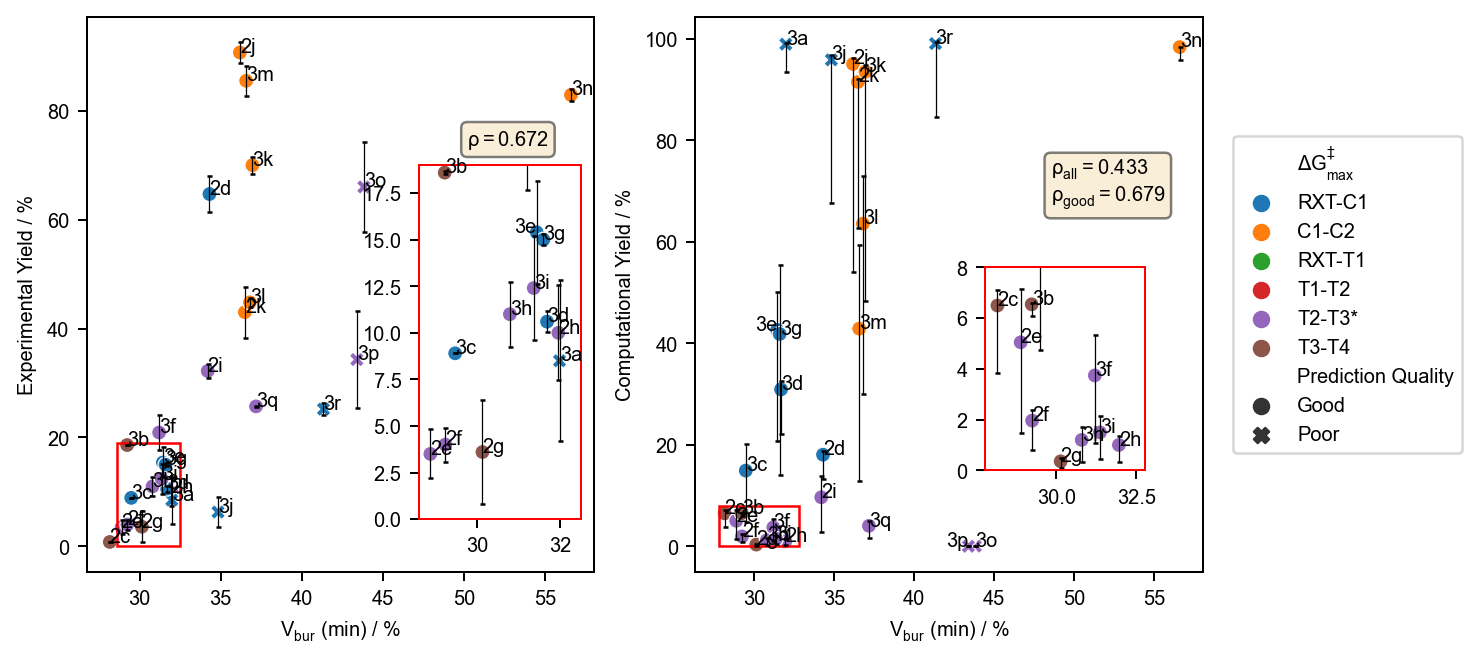

In [28]:
main_barrier_df['vbur_vbur_min_percent'] = main_barrier_df['vbur_vbur_min']/1.8

equiv = 3.5
hue_order = ['02-ts-rxt-c1', '04-ts-c1-c2', '12-ts-rxt-t1', '14-ts-t1-t2', f'17-ts-t2-t3-corr_{equiv}', '20-ts-t3-t4']

fig, ax = plt.subplots(1,2, figsize=(8,4), dpi=180)
x = 'vbur_vbur_min_percent'
y = 'nice_exp_yield'
g = sns.scatterplot(x=x, y=y, data=main_barrier_df, hue_order=hue_order, palette='tab10', hue=f'max_overall_corr_{equiv}_name',  style=main_barrier_df['prediction_quality'], ax=ax[0])
g5 = ax[0].errorbar(x=x, y=y, yerr='nice_exp_error', data=main_barrier_df, fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
for _, row in main_barrier_df.iterrows():
    ax[0].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)

ax[0].get_legend().set_visible(False)

x_inset1_start = 51.5/1.8
x_inset1_end = 58.5/1.8
y_inset1_start = 0
y_inset1_end = 19

rect1 = mpl.patches.Rectangle((x_inset1_start, y_inset1_start), x_inset1_end-x_inset1_start, y_inset1_end-y_inset1_start, linewidth=1, edgecolor='r', facecolor='none')
ax[0].add_patch(rect1)
    
axin1 = ax[0].inset_axes([85/1.8, 5, 18/1.8, 65], transform=ax[0].transData)
g_axin1 = sns.scatterplot(x=x, y=y, data=main_barrier_df, hue_order=hue_order, palette='tab10',style=main_barrier_df['prediction_quality'], hue=f'max_overall_corr_{equiv}_name', ax=axin1)
g5 = axin1.errorbar(x=x, y=y, yerr='nice_exp_error', data=main_barrier_df, fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
axin1.get_legend().set_visible(False)
axin1.set_xlim([x_inset1_start,x_inset1_end])
axin1.set_ylim([y_inset1_start,y_inset1_end])

for _, row in main_barrier_df.iterrows():
    if (axin1.get_xlim()[0] <= row[x] < axin1.get_xlim()[1]) & (axin1.get_ylim()[0] <= row[y] < axin1.get_ylim()[1]):
        if row['exp_name'] != '3e':
            axin1.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
        else:
            axin1.text(row[x]*0.9999, row[y]*1.001, row['exp_name'], fontsize=8, ha='right')

ax[0].set_xlabel("V$_{bur}$ (min) / %")
ax[0].set_ylabel("Experimental Yield / %")
axin1.set_xlabel("")
axin1.set_ylabel("")

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[0].text(0.75, 0.8, r'$\rho=%.3f$' % (pearsonr(main_barrier_df[y], main_barrier_df[x])[0]),
           transform=ax[0].transAxes, verticalalignment='top', bbox=props)

x = 'vbur_vbur_min_percent'
y = f'nice_comp_yield_{equiv}_main'
g2 = sns.scatterplot(x=x, y=y, data=main_barrier_df, palette='tab10',hue_order=hue_order, hue=f'max_overall_corr_{equiv}_name', style=main_barrier_df['prediction_quality'], ax=ax[1])
g5 = ax[1].errorbar(x=x, y=y, yerr=(main_barrier_df[f'nice_comp_yield_{equiv}_main_minus'], main_barrier_df[f'nice_comp_yield_{equiv}_main_plus']), data=main_barrier_df, 
                  fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
axin2_goleft = ['3e', '3p']
for _, row in main_barrier_df.iterrows():
    if row['exp_name'] not in axin2_goleft:
        ax[1].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
    else:
        ax[1].text(row[x]*0.9999, row[y]*1.001, row['exp_name'], fontsize=8, ha='right')

x_inset2_start = 50/1.8
x_inset2_end = 59/1.8
y_inset2_start = 0
y_inset2_end = 8

rect2 = mpl.patches.Rectangle((x_inset2_start, y_inset2_start), x_inset2_end-x_inset2_start, y_inset2_end-y_inset2_start, linewidth=1, edgecolor='r', facecolor='none')
ax[1].add_patch(rect2)
        
        
axin2 = ax[1].inset_axes([80/1.8, 15, 18/1.8, 40], transform=ax[1].transData)
g_axin2 = sns.scatterplot(x=x, y=y, data=main_barrier_df, palette='tab10', hue_order=hue_order, hue=f'max_overall_corr_{equiv}_name', style=main_barrier_df['prediction_quality'],ax=axin2)
g5 = axin2.errorbar(x=x, y=y, yerr=(main_barrier_df[f'nice_comp_yield_{equiv}_main_minus'], main_barrier_df[f'nice_comp_yield_{equiv}_main_plus']), data=main_barrier_df, 
                  fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
axin2.get_legend().set_visible(False)
axin2.set_xlim([x_inset2_start,x_inset2_end])
axin2.set_ylim([y_inset2_start,y_inset2_end])


for _, row in main_barrier_df.iterrows():
    if (axin2.get_xlim()[0] <= row[x] < axin2.get_xlim()[1]) & (axin2.get_ylim()[0] <= row[y] < axin2.get_ylim()[1]):
        if row['exp_name'] not in axin2_goleft:
            axin2.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
        else:
            axin2.text(row[x]*0.9999, row[y]*1.001, row['exp_name'], fontsize=8, ha='right')

ax[1].set_xlabel("V$_{bur}$ (min) / %")
ax[1].set_ylabel("Computational Yield / %")
axin2.set_xlabel("")
axin2.set_ylabel("")

all_r = pearsonr(main_barrier_df[x], main_barrier_df[y])[0]
di = main_barrier_df[main_barrier_df['prediction_quality'] == 'Good']
good_r = pearsonr(di[x], di[y])[0]
#dg = ff[ff['vbur_near_vbur_min_percent'] <= 75]
dh = main_barrier_df[main_barrier_df['prediction_quality'] == 'Good']
some_r = pearsonr(dh[x], dh[y])[0]


ax[1].text(0.7, 0.75, rf"$\rho_{{all}}={all_r:.3f}$"+"\n"+rf"$\rho_{{good}}={some_r:.3f}$", transform=ax[1].transAxes, verticalalignment='top', bbox=props)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,4,5,6,7,8,9]
text_list = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.04,0.5), loc="center left").get_texts()
text_list[0].set_text("$\Delta$G$^{\u2021}_{max}$")
text_list[1].set_text('RXT-C1')
text_list[2].set_text('C1-C2')
text_list[3].set_text('RXT-T1')
text_list[4].set_text('T1-T2')
text_list[5].set_text('T2-T3*')
text_list[6].set_text('T3-T4')
text_list[7].set_text('Prediction Quality')
#text_list[8].set_text()
#text_list[9].set_text()

for spine in axin1.spines.values():
    spine.set_edgecolor('r')
    
for spine in axin2.spines.values():
    spine.set_edgecolor('r')

plt.savefig('vburminyields.png', transparent=True, bbox_inches="tight")

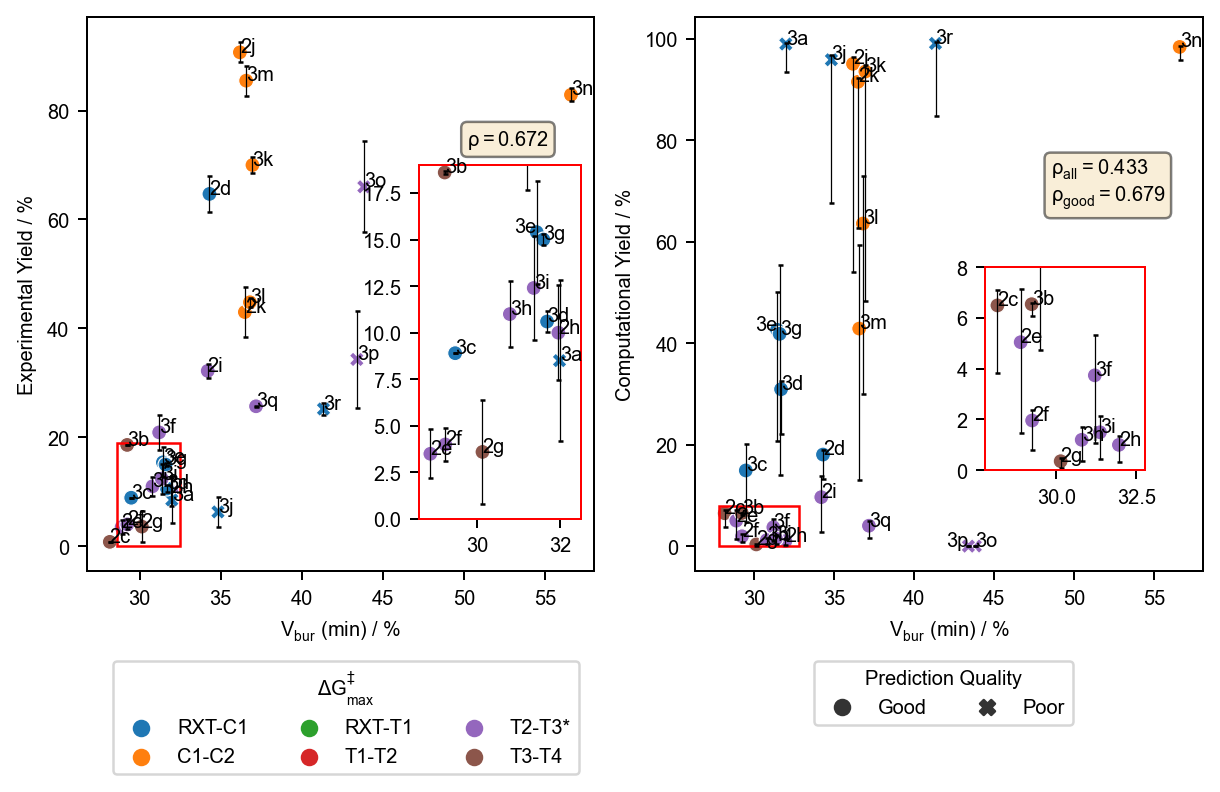

In [29]:
main_barrier_df['vbur_vbur_min_percent'] = main_barrier_df['vbur_vbur_min']/1.8

equiv = 3.5
hue_order = ['02-ts-rxt-c1', '04-ts-c1-c2', '12-ts-rxt-t1', '14-ts-t1-t2', f'17-ts-t2-t3-corr_{equiv}', '20-ts-t3-t4']

fig, ax = plt.subplots(1,2, figsize=(8,4), dpi=180)
x = 'vbur_vbur_min_percent'
y = 'nice_exp_yield'
g = sns.scatterplot(x=x, y=y, data=main_barrier_df, hue_order=hue_order, palette='tab10', hue=f'max_overall_corr_{equiv}_name',  style=main_barrier_df['prediction_quality'], ax=ax[0])
g5 = ax[0].errorbar(x=x, y=y, yerr='nice_exp_error', data=main_barrier_df, fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
for _, row in main_barrier_df.iterrows():
    ax[0].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)

ax[0].get_legend().set_visible(False)

x_inset1_start = 51.5/1.8
x_inset1_end = 58.5/1.8
y_inset1_start = 0
y_inset1_end = 19

rect1 = mpl.patches.Rectangle((x_inset1_start, y_inset1_start), x_inset1_end-x_inset1_start, y_inset1_end-y_inset1_start, linewidth=1, edgecolor='r', facecolor='none')
ax[0].add_patch(rect1)
    
axin1 = ax[0].inset_axes([85/1.8, 5, 18/1.8, 65], transform=ax[0].transData)
g_axin1 = sns.scatterplot(x=x, y=y, data=main_barrier_df, hue_order=hue_order, palette='tab10',style=main_barrier_df['prediction_quality'], hue=f'max_overall_corr_{equiv}_name', ax=axin1)
g5 = axin1.errorbar(x=x, y=y, yerr='nice_exp_error', data=main_barrier_df, fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
axin1.get_legend().set_visible(False)
axin1.set_xlim([x_inset1_start,x_inset1_end])
axin1.set_ylim([y_inset1_start,y_inset1_end])

for _, row in main_barrier_df.iterrows():
    if (axin1.get_xlim()[0] <= row[x] < axin1.get_xlim()[1]) & (axin1.get_ylim()[0] <= row[y] < axin1.get_ylim()[1]):
        if row['exp_name'] != '3e':
            axin1.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
        else:
            axin1.text(row[x]*0.9999, row[y]*1.001, row['exp_name'], fontsize=8, ha='right')

ax[0].set_xlabel("V$_{bur}$ (min) / %")
ax[0].set_ylabel("Experimental Yield / %")
axin1.set_xlabel("")
axin1.set_ylabel("")

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[0].text(0.75, 0.8, r'$\rho=%.3f$' % (pearsonr(main_barrier_df[y], main_barrier_df[x])[0]),
           transform=ax[0].transAxes, verticalalignment='top', bbox=props)

x = 'vbur_vbur_min_percent'
y = f'nice_comp_yield_{equiv}_main'
g2 = sns.scatterplot(x=x, y=y, data=main_barrier_df, palette='tab10',hue_order=hue_order, hue=f'max_overall_corr_{equiv}_name', style=main_barrier_df['prediction_quality'], ax=ax[1])
g5 = ax[1].errorbar(x=x, y=y, yerr=(main_barrier_df[f'nice_comp_yield_{equiv}_main_minus'], main_barrier_df[f'nice_comp_yield_{equiv}_main_plus']), data=main_barrier_df, 
                  fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
axin2_goleft = ['3e', '3p']
for _, row in main_barrier_df.iterrows():
    if row['exp_name'] not in axin2_goleft:
        ax[1].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
    else:
        ax[1].text(row[x]*0.9999, row[y]*1.001, row['exp_name'], fontsize=8, ha='right')

x_inset2_start = 50/1.8
x_inset2_end = 59/1.8
y_inset2_start = 0
y_inset2_end = 8

rect2 = mpl.patches.Rectangle((x_inset2_start, y_inset2_start), x_inset2_end-x_inset2_start, y_inset2_end-y_inset2_start, linewidth=1, edgecolor='r', facecolor='none')
ax[1].add_patch(rect2)
        
        
axin2 = ax[1].inset_axes([80/1.8, 15, 18/1.8, 40], transform=ax[1].transData)
g_axin2 = sns.scatterplot(x=x, y=y, data=main_barrier_df, palette='tab10', hue_order=hue_order, hue=f'max_overall_corr_{equiv}_name', style=main_barrier_df['prediction_quality'],ax=axin2)
g5 = axin2.errorbar(x=x, y=y, yerr=(main_barrier_df[f'nice_comp_yield_{equiv}_main_minus'], main_barrier_df[f'nice_comp_yield_{equiv}_main_plus']), data=main_barrier_df, 
                  fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
axin2.get_legend().set_visible(False)
axin2.set_xlim([x_inset2_start,x_inset2_end])
axin2.set_ylim([y_inset2_start,y_inset2_end])


for _, row in main_barrier_df.iterrows():
    if (axin2.get_xlim()[0] <= row[x] < axin2.get_xlim()[1]) & (axin2.get_ylim()[0] <= row[y] < axin2.get_ylim()[1]):
        if row['exp_name'] not in axin2_goleft:
            axin2.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
        else:
            axin2.text(row[x]*0.9999, row[y]*1.001, row['exp_name'], fontsize=8, ha='right')

ax[1].set_xlabel("V$_{bur}$ (min) / %")
ax[1].set_ylabel("Computational Yield / %")
axin2.set_xlabel("")
axin2.set_ylabel("")

all_r = pearsonr(main_barrier_df[x], main_barrier_df[y])[0]
di = main_barrier_df[main_barrier_df['prediction_quality'] == 'Good']
good_r = pearsonr(di[x], di[y])[0]
#dg = ff[ff['vbur_near_vbur_min_percent'] <= 75]
dh = main_barrier_df[main_barrier_df['prediction_quality'] == 'Good']
some_r = pearsonr(dh[x], dh[y])[0]


ax[1].text(0.7, 0.75, rf"$\rho_{{all}}={all_r:.3f}$"+"\n"+rf"$\rho_{{good}}={some_r:.3f}$", transform=ax[1].transAxes, verticalalignment='top', bbox=props)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,4,5,6,7,8,9]

ax[0].get_legend().remove()
ax[1].get_legend().remove()

# Create the first legend for "ΔG‡max"
legend1 = fig.legend([handles[idx] for idx in order[1:7]], 
                    [labels[idx] for idx in order[1:7]], 
                    bbox_to_anchor=(0.305, 0), 
                    loc="upper center", 
                    ncol=3, 
                    title="$\Delta$G$^{\u2021}_{max}$")

# Create the second legend for "Prediction Quality"
legend2 = fig.legend([handles[idx] for idx in order[8:10]], 
                    [labels[idx] for idx in order[8:10]], 
                    bbox_to_anchor=(0.72, 0), 
                    loc="upper center", 
                    ncol=2, 
                    title="Prediction Quality")


# Set the text for each legend item
text_list1 = legend1.get_texts()
text_list2 = legend2.get_texts()

text_list1[0].set_text('RXT-C1')
text_list1[1].set_text('C1-C2')
text_list1[2].set_text('RXT-T1')
text_list1[3].set_text('T1-T2')
text_list1[4].set_text('T2-T3*')
text_list1[5].set_text('T3-T4')


for spine in axin1.spines.values():
    spine.set_edgecolor('r')
    
for spine in axin2.spines.values():
    spine.set_edgecolor('r')

plt.savefig('vburminyields_landscape.png', transparent=True, bbox_inches="tight")

## Correlation analysis

In [30]:
from scipy.stats import pearsonr

kraken_columns = [
    'dipolemoment_boltz', 'dipolemoment_delta', 'dipolemoment_max',
    'dipolemoment_min', 'dipolemoment_vburminconf', 'E_oxidation_boltz',
    'E_reduction_boltz', 'E_solv_cds_boltz', 'E_solv_elstat_boltz',
    'E_solv_total_boltz', 'efg_amp_P_boltz', 'efgtens_xx_P_boltz',
    'efgtens_yy_P_boltz', 'efgtens_zz_P_boltz', 'fmo_e_homo_boltz',
    'fmo_e_lumo_boltz', 'fmo_eta_boltz', 'fmo_mu_boltz', 'fmo_omega_boltz',
    'fukui_m_boltz', 'fukui_p_boltz', 'nbo_bd_e_avg_boltz', 'nbo_bd_e_max_boltz',
    'nbo_bd_occ_avg_boltz', 'nbo_bd_occ_min_boltz', 'nbo_bds_e_avg_boltz',
    'nbo_bds_e_min_boltz', 'nbo_bds_occ_avg_boltz', 'nbo_bds_occ_max_boltz',
    'nbo_lp_P_e_boltz', 'nbo_lp_P_occ_boltz', 'nbo_lp_P_percent_s_boltz',
    'nbo_P_boltz', 'nbo_P_ra_boltz', 'nbo_P_rc_boltz', 'nmr_P_boltz',
    'nmrtens_sxx_P_boltz', 'nmrtens_syy_P_boltz', 'nmrtens_szz_P_boltz',
    'nuesp_P_boltz', 'Pint_dP_boltz', 'Pint_P_int_boltz', 'Pint_P_max_boltz',
    'Pint_P_min_boltz', 'pyr_alpha_boltz', 'pyr_alpha_delta', 'pyr_alpha_max',
    'pyr_alpha_min', 'pyr_alpha_vburminconf', 'pyr_P_boltz', 'pyr_P_delta',
    'pyr_P_max', 'pyr_P_min', 'pyr_P_vburminconf', 'qpole_amp_boltz',
    'qpole_amp_delta', 'qpole_amp_max', 'qpole_amp_min', 'qpole_amp_vburminconf',
    'qpoletens_xx_boltz', 'qpoletens_xx_delta', 'qpoletens_xx_max',
    'qpoletens_xx_min', 'qpoletens_xx_vburminconf', 'qpoletens_yy_boltz',
    'qpoletens_yy_delta', 'qpoletens_yy_max', 'qpoletens_yy_min',
    'qpoletens_yy_vburminconf', 'qpoletens_zz_boltz', 'qpoletens_zz_delta',
    'qpoletens_zz_max', 'qpoletens_zz_min', 'qpoletens_zz_vburminconf',
    'somo_ra_boltz', 'somo_rc_boltz', 'sphericity_boltz', 'spindens_P_ra_boltz',
    'spindens_P_rc_boltz', 'sterimol_B1_boltz', 'sterimol_B1_delta',
    'sterimol_B1_max', 'sterimol_B1_min', 'sterimol_B1_vburminconf',
    'sterimol_B5_boltz', 'sterimol_B5_delta', 'sterimol_B5_max', 'sterimol_B5_min',
    'sterimol_B5_vburminconf', 'sterimol_burB1_boltz', 'sterimol_burB1_delta',
    'sterimol_burB1_max', 'sterimol_burB1_min', 'sterimol_burB1_vburminconf',
    'sterimol_burB5_boltz', 'sterimol_burB5_delta', 'sterimol_burB5_max',
    'sterimol_burB5_min', 'sterimol_burB5_vburminconf', 'sterimol_burL_boltz',
    'sterimol_burL_delta', 'sterimol_burL_max', 'sterimol_burL_min',
    'sterimol_burL_vburminconf', 'sterimol_L_boltz', 'sterimol_L_delta',
    'sterimol_L_max', 'sterimol_L_min', 'sterimol_L_vburminconf',
    'surface_area_boltz', 'vbur_far_vbur_boltz', 'vbur_far_vbur_delta',
    'vbur_far_vbur_max', 'vbur_far_vbur_min', 'vbur_far_vbur_vburminconf',
    'vbur_far_vtot_boltz', 'vbur_far_vtot_delta', 'vbur_far_vtot_max',
    'vbur_far_vtot_min', 'vbur_far_vtot_vburminconf', 'vbur_max_delta_qvbur_boltz',
    'vbur_max_delta_qvbur_delta', 'vbur_max_delta_qvbur_max',
    'vbur_max_delta_qvbur_min', 'vbur_max_delta_qvbur_vburminconf',
    'vbur_max_delta_qvtot_boltz', 'vbur_max_delta_qvtot_delta',
    'vbur_max_delta_qvtot_max', 'vbur_max_delta_qvtot_min',
    'vbur_max_delta_qvtot_vburminconf', 'vbur_near_vbur_boltz',
    'vbur_near_vbur_delta', 'vbur_near_vbur_max', 'vbur_near_vbur_min',
    'vbur_near_vbur_vburminconf', 'vbur_near_vtot_boltz', 'vbur_near_vtot_delta',
    'vbur_near_vtot_max', 'vbur_near_vtot_min', 'vbur_near_vtot_vburminconf',
    'vbur_ovbur_max_boltz', 'vbur_ovbur_max_delta', 'vbur_ovbur_max_max',
    'vbur_ovbur_max_min', 'vbur_ovbur_max_vburminconf', 'vbur_ovbur_min_boltz',
    'vbur_ovbur_min_delta', 'vbur_ovbur_min_max', 'vbur_ovbur_min_min',
    'vbur_ovbur_min_vburminconf', 'vbur_ovtot_max_boltz', 'vbur_ovtot_max_delta',
    'vbur_ovtot_max_max', 'vbur_ovtot_max_min', 'vbur_ovtot_max_vburminconf',
    'vbur_ovtot_min_boltz', 'vbur_ovtot_min_delta', 'vbur_ovtot_min_max',
    'vbur_ovtot_min_min', 'vbur_ovtot_min_vburminconf', 'vbur_qvbur_max_boltz',
    'vbur_qvbur_max_delta', 'vbur_qvbur_max_max', 'vbur_qvbur_max_min',
    'vbur_qvbur_max_vburminconf', 'vbur_qvbur_min_boltz', 'vbur_qvbur_min_delta',
    'vbur_qvbur_min_max', 'vbur_qvbur_min_min', 'vbur_qvbur_min_vburminconf',
    'vbur_qvtot_max_boltz', 'vbur_qvtot_max_delta', 'vbur_qvtot_max_max',
    'vbur_qvtot_max_min', 'vbur_qvtot_max_vburminconf', 'vbur_qvtot_min_boltz',
    'vbur_qvtot_min_delta', 'vbur_qvtot_min_max', 'vbur_qvtot_min_min',
    'vbur_qvtot_min_vburminconf', 'vbur_ratio_vbur_vtot_boltz', 'vbur_vbur_boltz',
    'vbur_vbur_delta', 'vbur_vbur_max', 'vbur_vbur_min', 'vbur_vbur_vburminconf',
    'vbur_vtot_boltz', 'vmin_r_boltz', 'vmin_vmin_boltz', 'volume_boltz'
]

equiv = 3.5
hue_order = ['02-ts-rxt-c1', '04-ts-c1-c2', '12-ts-rxt-t1', '14-ts-t1-t2', f'17-ts-t2-t3-corr_{equiv}', '20-ts-t3-t4']

kraken_full = main_barrier_df[['ligand_name', 'exp_name', 'prediction_quality', f'max_overall_corr_{equiv}_name', 'nice_exp_yield', 'nice_exp_error', f'nice_comp_yield_{equiv}_main', f'nice_comp_yield_{equiv}_main_minus', f'nice_comp_yield_{equiv}_main_plus']+kraken_columns].copy()

kraken_good = main_barrier_df[main_barrier_df['prediction_quality'] == "Good"].copy()


In [31]:
get_correlation = False

if get_correlation:
    exp_full_corr_dict = {}
    exp_good_corr_dict = {}
    comp_full_corr_dict = {}
    comp_good_corr_dict = {}
    for descriptor in kraken_columns:
        exp_full_corr_dict[descriptor] = pearsonr(kraken_full[descriptor], kraken_full['nice_exp_yield'])[0]
        exp_good_corr_dict[descriptor] = pearsonr(kraken_good[descriptor], kraken_good['nice_exp_yield'])[0]
        comp_full_corr_dict[descriptor] = pearsonr(kraken_full[descriptor], kraken_full['nice_comp_yield_3.5_main'])[0]
        comp_good_corr_dict[descriptor] = pearsonr(kraken_good[descriptor], kraken_good['nice_comp_yield_3.5_main'])[0]
        
    corr_df = pd.DataFrame(data=[exp_full_corr_dict,exp_good_corr_dict,comp_full_corr_dict,comp_good_corr_dict,]).T

    corr_df.columns = ['exp_full', 'exp_good', 'comp_full', 'comp_good']
    for col in corr_df.columns:
        corr_df[col+'_abs'] = corr_df[col].abs()
        corr_df[col+'_abs_rank'] = corr_df[col+'_abs'].rank(ascending=False)

    corr_df.to_csv('corr_dict.csv', index_label='descriptor')
else:
    try:
        corr_df = pd.read_csv('corr_dict.csv')
    except FileNotFoundError:
        print("Run correlation analysis!")

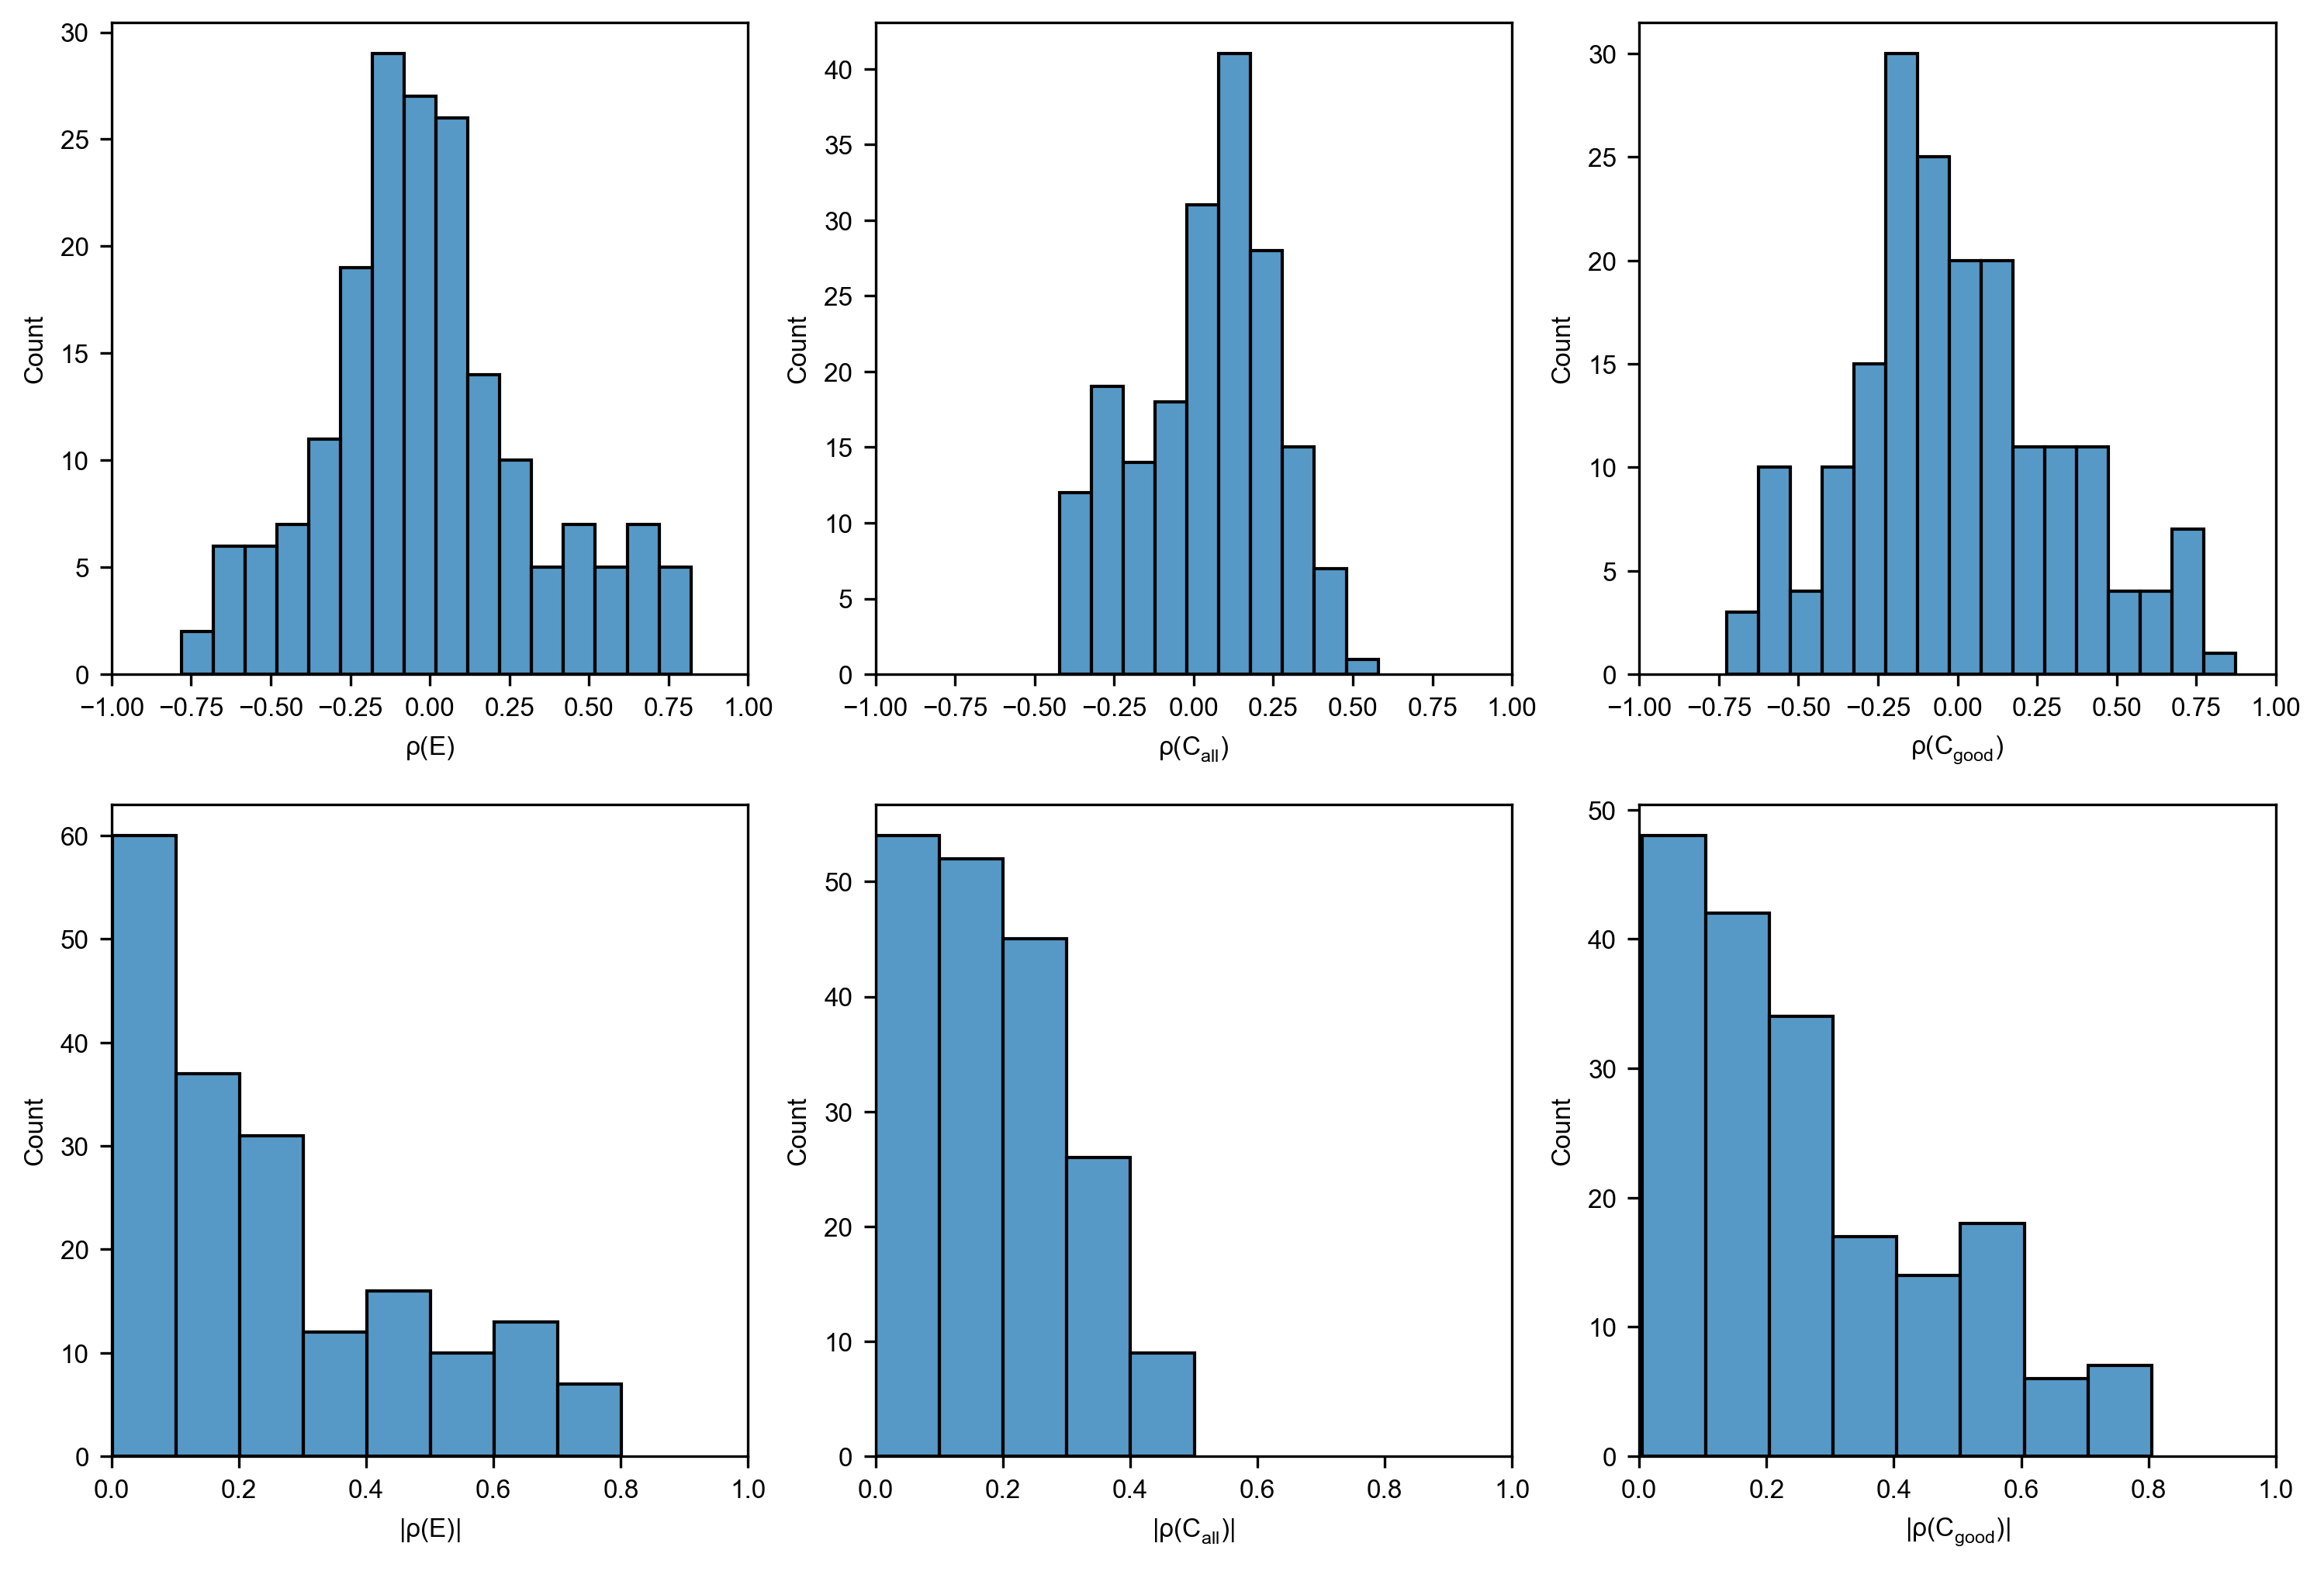

In [32]:
nrows = 2
ncols = 3
fig, ax = plt.subplots(nrows,ncols, figsize=(12,8), dpi=300)

axis_names = [[r"$\rho(E)$", r"$\rho(C_{all})$", r"$\rho(C_{good})$"],[r"$|\rho(E)|$", r"$|\rho(C_{all})|$", r"$|\rho(C_{good})|$"]]

desired_axes = ['exp_full', 'comp_full', 'comp_good', 'exp_full_abs', 'comp_full_abs', 'comp_good_abs', ]

for k, col in enumerate(desired_axes):
    i = k // ncols
    j = k % ncols
    sns.histplot(x=corr_df[col], data=corr_df, ax=ax[i][j], binwidth=0.1)
    if i == 1:
        ax[i][j].set_xlim([0, 1])
    else:
        ax[i][j].set_xlim([-1, 1])
    ax[i][j].set_xlabel(axis_names[i][j])

plt.savefig("corrhist.png", transparent=True, bbox_inches='tight')

In [33]:
corr_df

,descriptor,exp_full,exp_good,comp_full,comp_good,exp_full_abs,exp_full_abs_rank,exp_good_abs,exp_good_abs_rank,comp_full_abs,comp_full_abs_rank,comp_good_abs,comp_good_abs_rank
0,dipolemoment_boltz,-0.051894,-0.391119,0.203703,-0.163559,0.051894,158.0,0.391119,52.0,0.203703,79.0,0.163559,113.0
1,dipolemoment_delta,-0.149774,-0.177987,-0.088959,-0.208852,0.149774,108.0,0.177987,111.0,0.088959,139.0,0.208852,96.0
2,dipolemoment_max,-0.148232,-0.249172,0.052322,-0.248888,0.148232,110.0,0.249172,84.0,0.052322,157.0,0.248888,82.0
3,dipolemoment_min,-0.026539,-0.079911,0.244187,0.023723,0.026539,175.0,0.079911,152.0,0.244187,60.0,0.023723,181.0
4,dipolemoment_vburminconf,-0.183333,-0.269056,0.080357,-0.225478,0.183333,95.0,0.269056,73.0,0.080357,143.0,0.225478,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,vbur_vbur_vburminconf,0.672276,0.717932,0.432600,0.679478,0.672276,10.5,0.717932,13.5,0.432600,5.5,0.679478,9.5
186,vbur_vtot_boltz,0.029987,0.018639,0.173643,0.079287,0.029987,169.0,0.018639,178.0,0.173643,91.0,0.079287,154.0
187,vmin_r_boltz,-0.291475,-0.264527,0.090477,-0.181050,0.291475,62.0,0.264527,77.0,0.090477,137.0,0.181050,103.0
188,vmin_vmin_boltz,-0.136090,-0.148382,-0.331847,-0.301891,0.136090,118.0,0.148382,125.0,0.331847,21.0,0.301891,65.0


KeyError: 'nice_exp_yield'

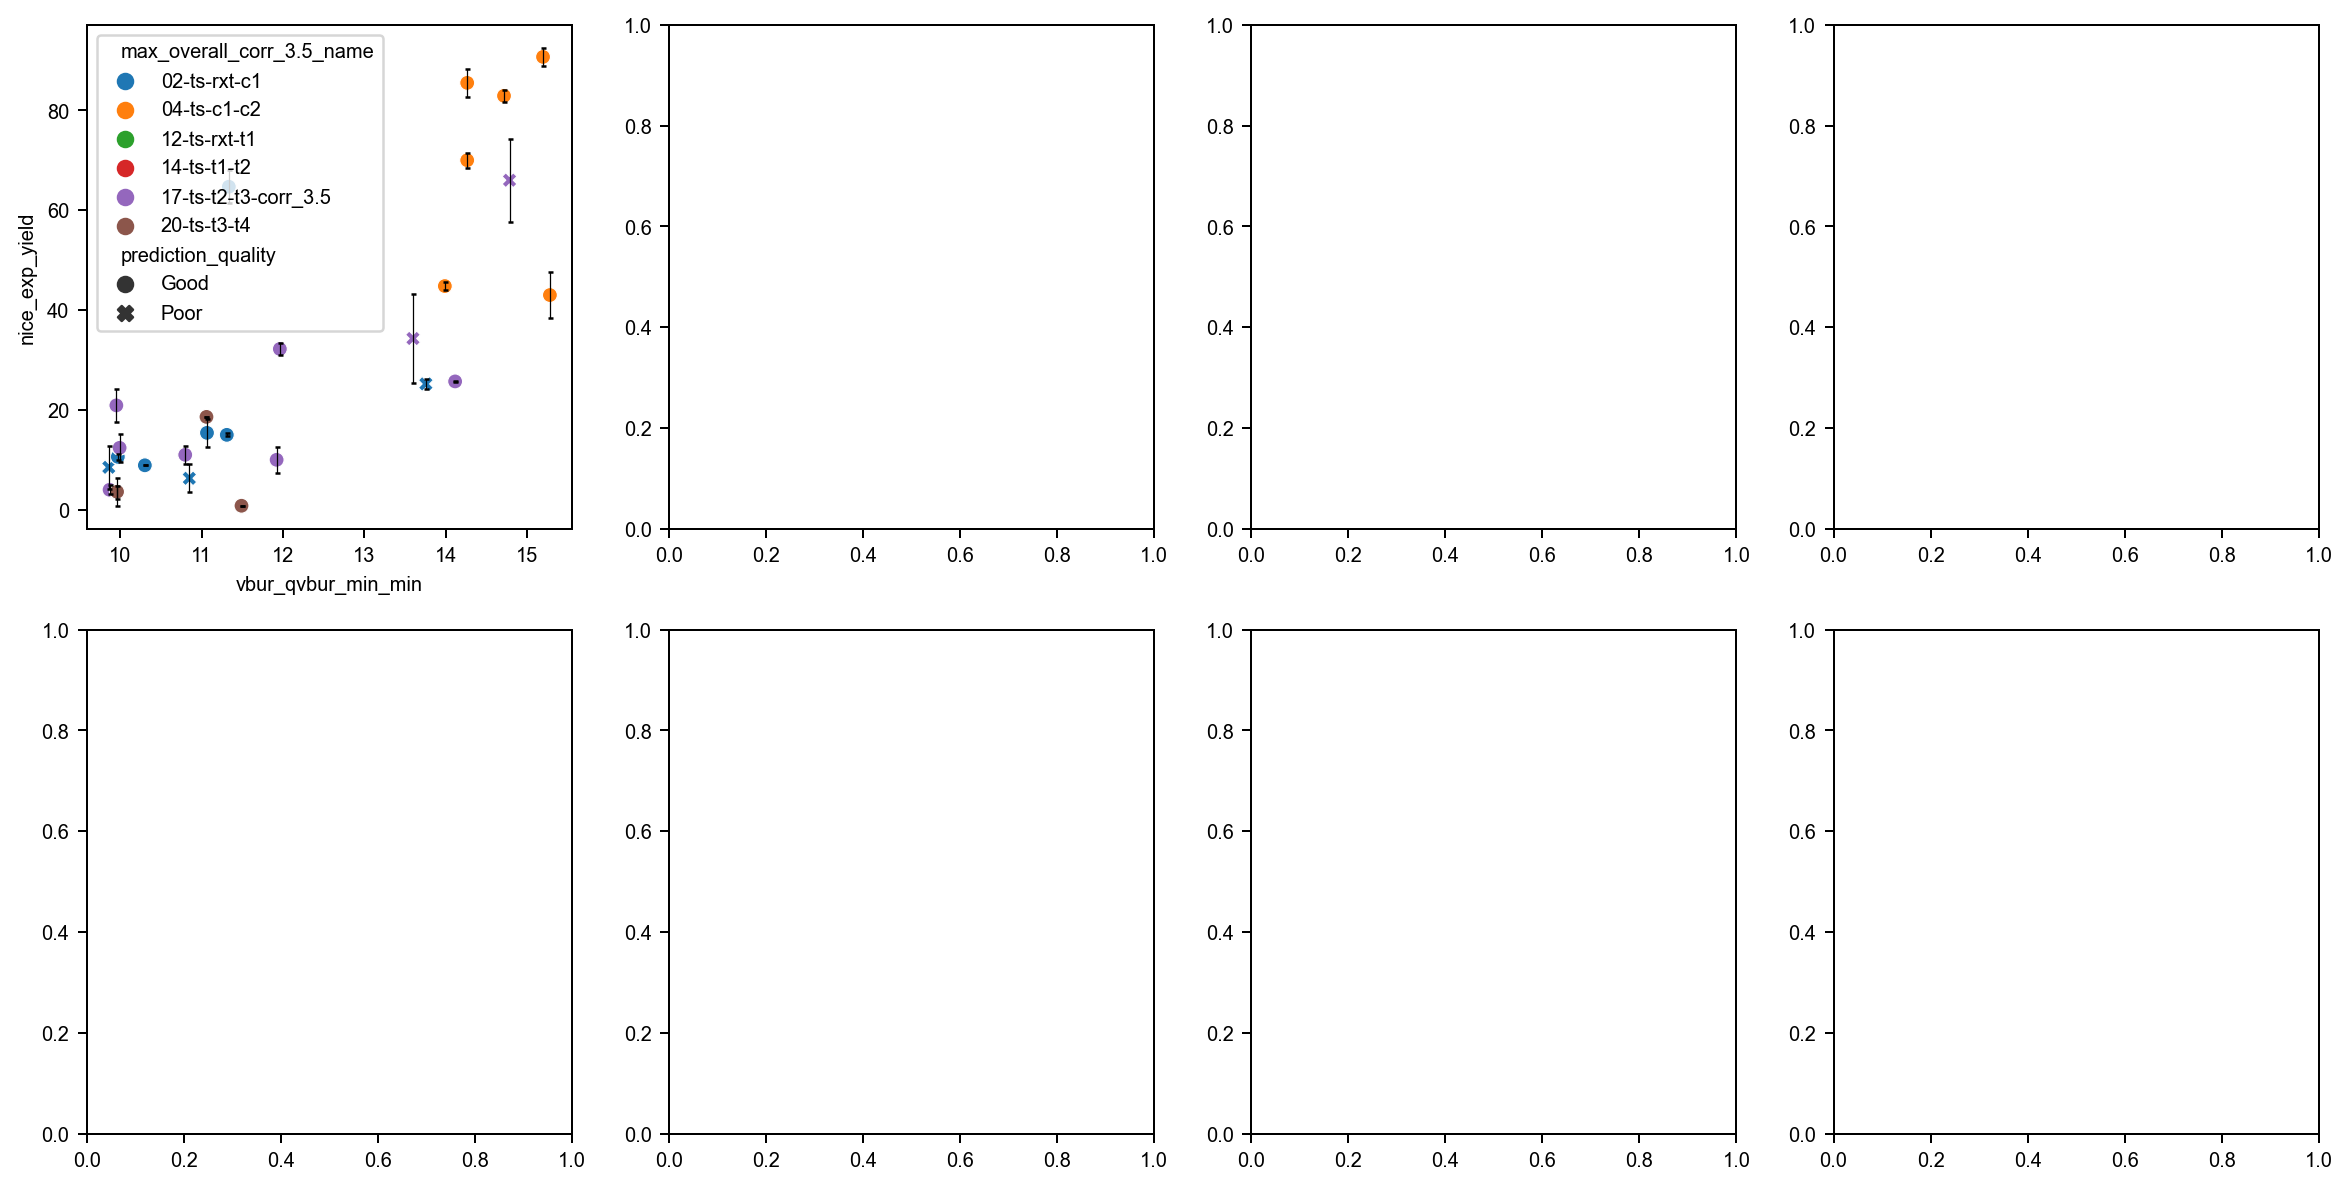

In [34]:
interest = 'exp_full'
#corr_hg[corr_hg[interest] >= 0.4].sort_values(by=interest,ascending=False)
corr_df_tmp = corr_df.sort_values(by='exp_full_abs_rank',ascending=True).head(8)

nrows = 2
ncols = 4

fig, ax = plt.subplots(nrows,ncols, figsize=(16,8), dpi=180)
equiv = 3.5
hue_order = ['02-ts-rxt-c1', '04-ts-c1-c2', '12-ts-rxt-t1', '14-ts-t1-t2', f'17-ts-t2-t3-corr_{equiv}', '20-ts-t3-t4']

for n, col in enumerate(corr_df_tmp['descriptor']):
    i = n // ncols
    j = n % ncols
    x = col
    y = 'nice_exp_yield'
    g = sns.scatterplot(x=x, y=y, data=kraken_full, hue_order=hue_order, palette='tab10', style=kraken_full['prediction_quality'], hue=f'max_overall_corr_{equiv}_name', ax=ax[i][j])
    g5 = ax[i][j].errorbar(x=x, y=y, yerr='nice_exp_error', data=kraken_full, fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
    for _, row in kraken_df.iterrows():
        ax[i][j].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
    ax[i][j].legend_.remove()
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax[i][j].text(0.75, 0.5, r'$\rho=%.3f$' % (corr_df[corr_df['descriptor'] == col][interest]),
           transform=ax[i][j].transAxes, verticalalignment='top', bbox=props)
    ax[i][j].set_ylabel("Experimental Yield / %")
    ax[i][j].set_ylim(0,100)


text_list = plt.legend(bbox_to_anchor=(1.04,1), loc="center left").get_texts()
text_list[0].set_text("$\Delta$G$^{\u2021}_{max}$")
text_list[1].set_text('RXT-C1')
text_list[2].set_text('C1-C2')
text_list[3].set_text('RXT-T1')
text_list[4].set_text('T1-T2')
text_list[5].set_text('T2-T3*')
text_list[6].set_text('T3-T4')
text_list[7].set_text('Prediction Quality')

#ax.set_xlabel("V$_{bur}$ (min) / %")


plt.savefig("expfullcorrplots.png", transparent=True, bbox_inches='tight')

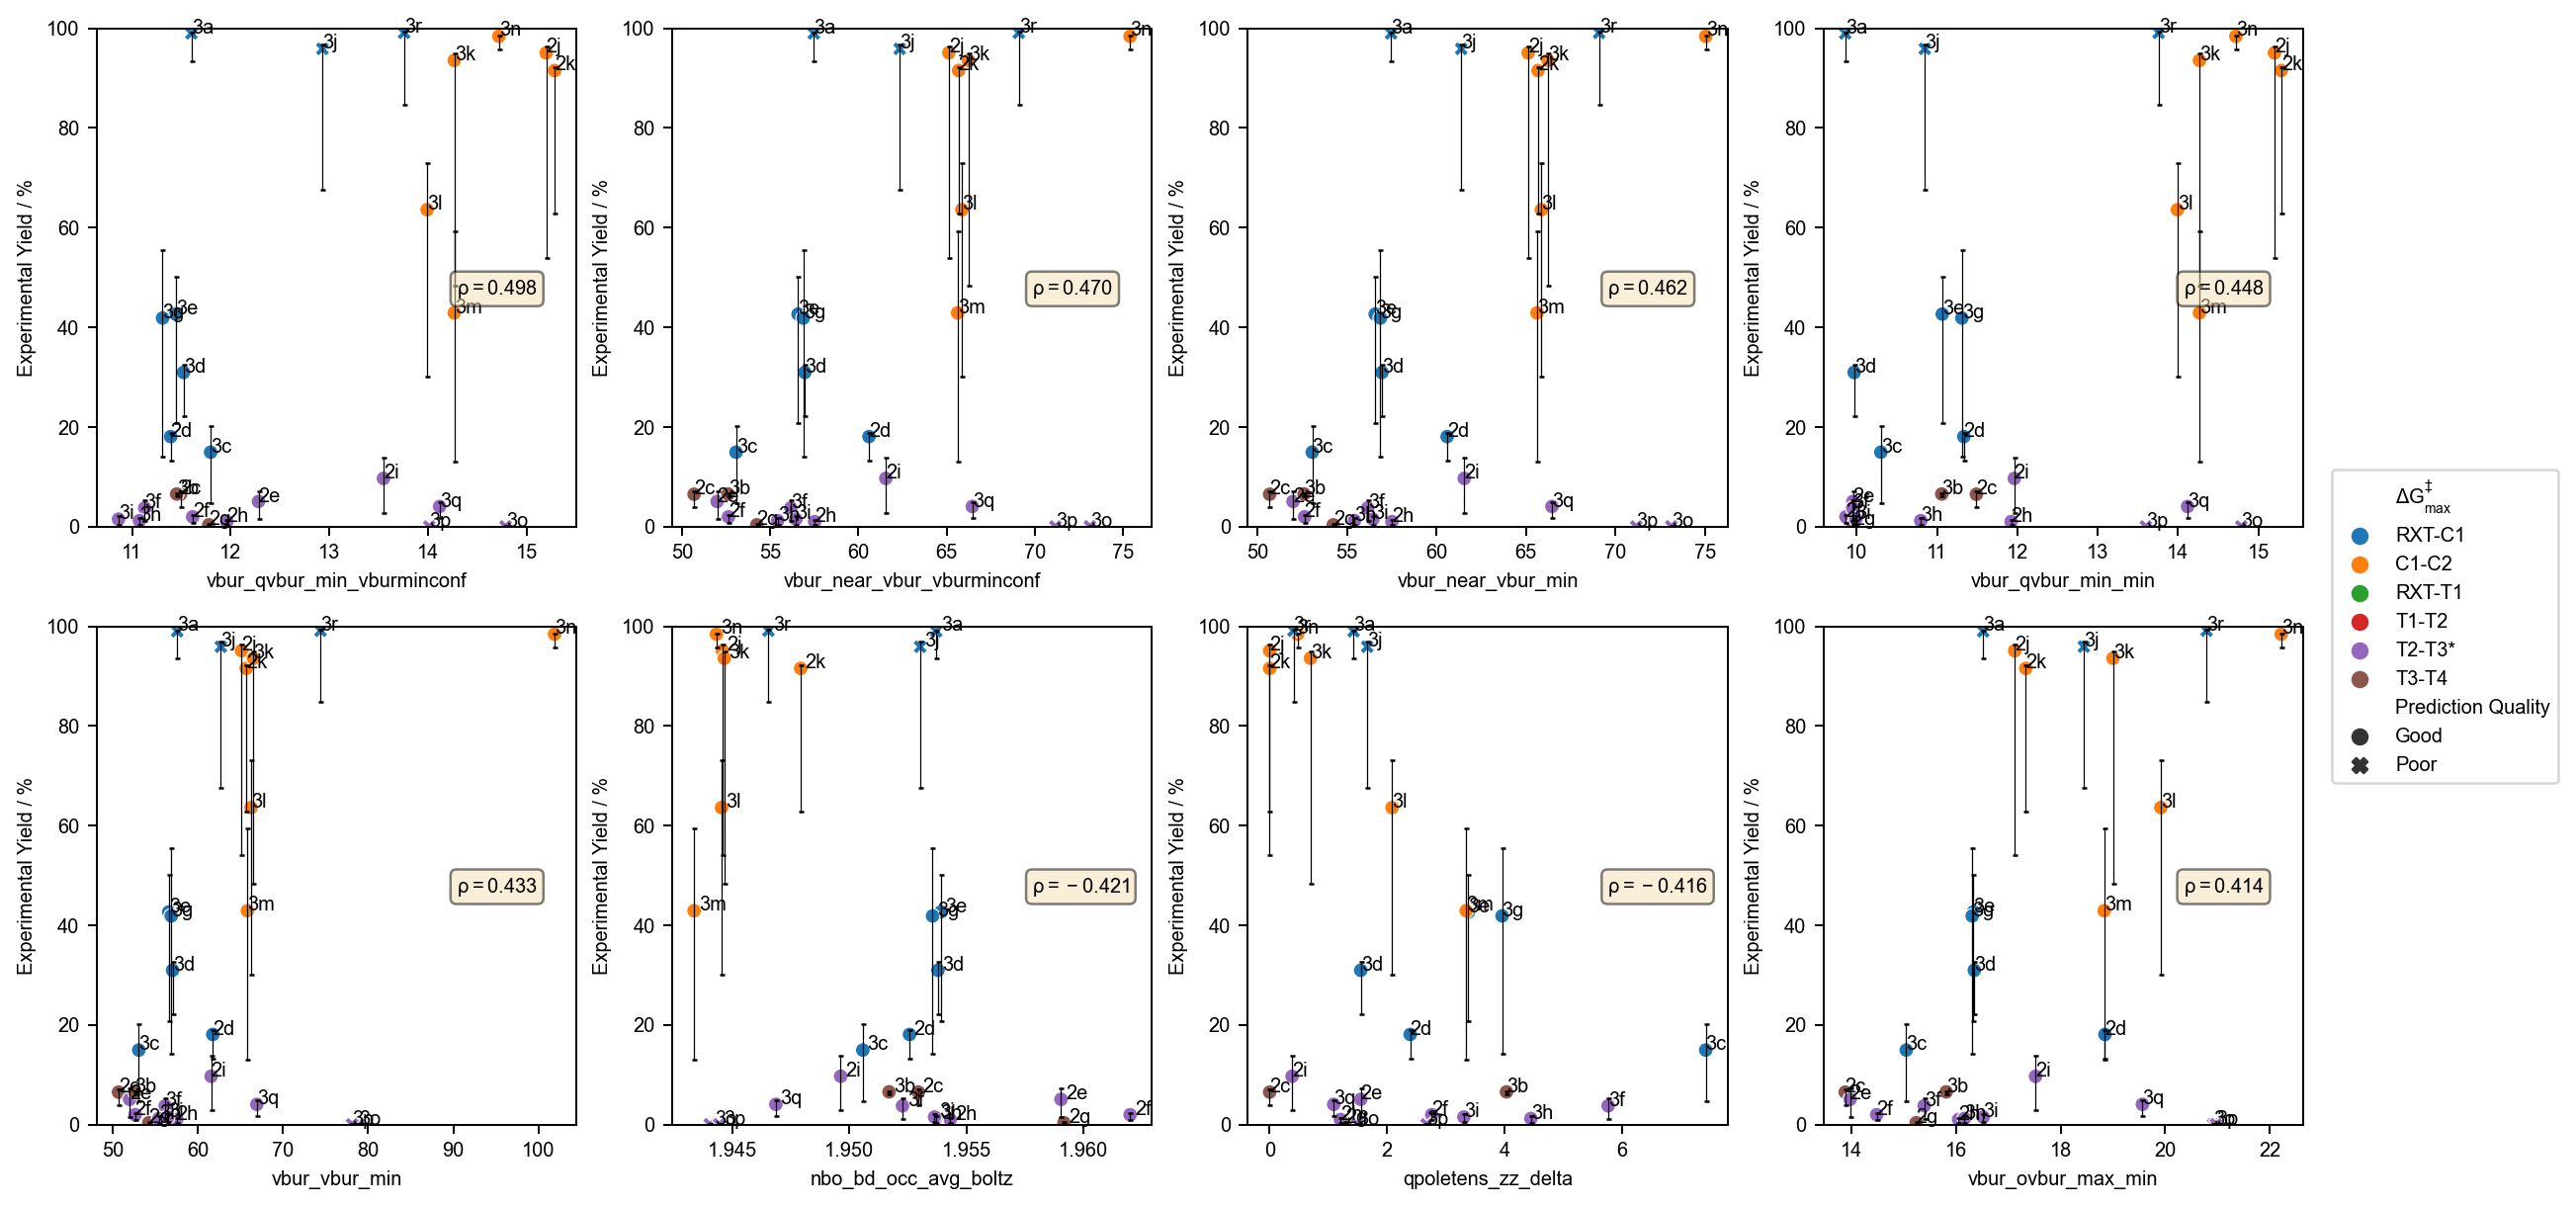

In [ ]:
interest = 'comp_full'
#corr_hg[corr_hg[interest] >= 0.4].sort_values(by=interest,ascending=False)
corr_df_tmp = corr_df.sort_values(by='comp_full_abs_rank',ascending=True).head(8)

# vbur_vbur_vburminconf is equal to vbur_vbur_min
descriptor_list = ['vbur_qvbur_min_vburminconf',
 'vbur_near_vbur_vburminconf',
 'vbur_near_vbur_min',
 'vbur_qvbur_min_min',
 'vbur_vbur_min',
 'nbo_bd_occ_avg_boltz',
 'qpoletens_zz_delta',
 'vbur_ovbur_max_min',]

nrows = 2
ncols = 4

fig, ax = plt.subplots(nrows,ncols, figsize=(16,8), dpi=180)
equiv = 3.5
hue_order = ['02-ts-rxt-c1', '04-ts-c1-c2', '12-ts-rxt-t1', '14-ts-t1-t2', f'17-ts-t2-t3-corr_{equiv}', '20-ts-t3-t4']

for n, col in enumerate(descriptor_list):
    i = n // ncols
    j = n % ncols
    x = col
    y = f'nice_comp_yield_{equiv}_main'
    g = sns.scatterplot(x=x, y=y, data=kraken_full, hue_order=hue_order, palette='tab10', style=kraken_full['prediction_quality'], hue=f'max_overall_corr_{equiv}_name', ax=ax[i][j])
    g5 = ax[i][j].errorbar(x=x, y=y, yerr=(kraken_full[f'nice_comp_yield_{equiv}_main_minus'], kraken_full[f'nice_comp_yield_{equiv}_main_plus']), data=kraken_full, fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
    for _, row in kraken_df.iterrows():
        ax[i][j].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
    ax[i][j].legend_.remove()
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax[i][j].text(0.75, 0.5, r'$\rho=%.3f$' % (corr_df[corr_df['descriptor'] == col][interest]),
           transform=ax[i][j].transAxes, verticalalignment='top', bbox=props)
    ax[i][j].set_ylabel("Experimental Yield / %")
    ax[i][j].set_ylim(0,100)


text_list = plt.legend(bbox_to_anchor=(1.04,1), loc="center left").get_texts()
text_list[0].set_text("$\Delta$G$^{\u2021}_{max}$")
text_list[1].set_text('RXT-C1')
text_list[2].set_text('C1-C2')
text_list[3].set_text('RXT-T1')
text_list[4].set_text('T1-T2')
text_list[5].set_text('T2-T3*')
text_list[6].set_text('T3-T4')
text_list[7].set_text('Prediction Quality')

#ax.set_xlabel("V$_{bur}$ (min) / %")


plt.savefig("compfullcorrplots.png", transparent=True, bbox_inches='tight')

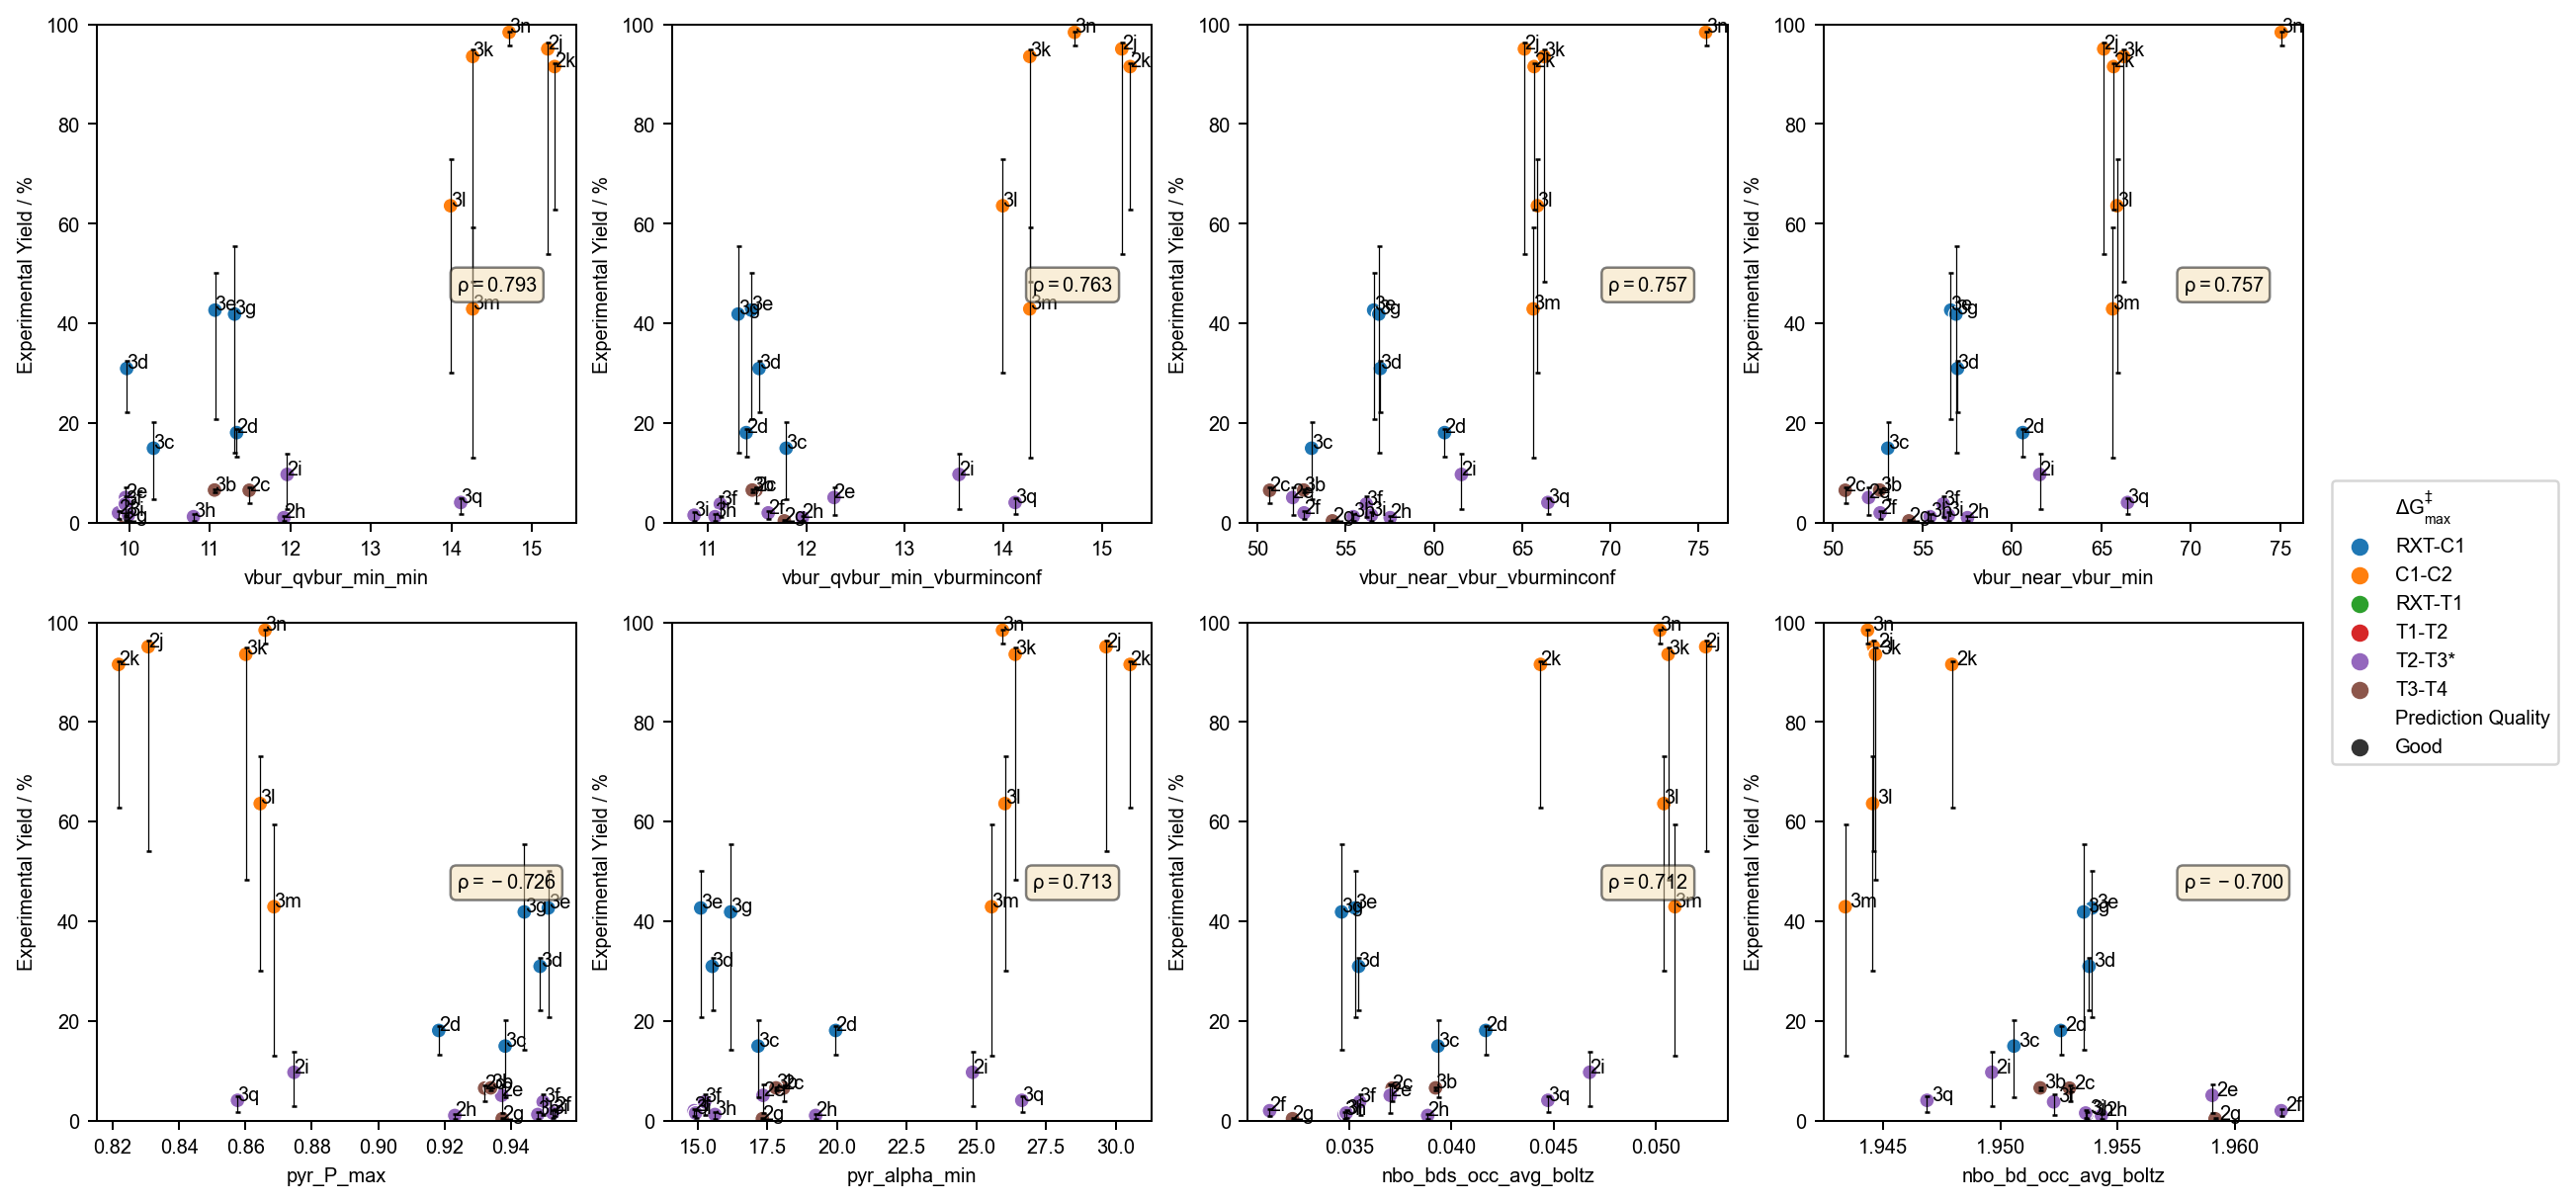

In [ ]:
interest = 'comp_good'
#corr_hg[corr_hg[interest] >= 0.4].sort_values(by=interest,ascending=False)
corr_df_tmp = corr_df.sort_values(by='comp_good_abs_rank',ascending=True).head(8)

nrows = 2
ncols = 4

fig, ax = plt.subplots(nrows,ncols, figsize=(16,8), dpi=180)
equiv = 3.5
hue_order = ['02-ts-rxt-c1', '04-ts-c1-c2', '12-ts-rxt-t1', '14-ts-t1-t2', f'17-ts-t2-t3-corr_{equiv}', '20-ts-t3-t4']

for n, col in enumerate(corr_df_tmp['descriptor']):
    i = n // ncols
    j = n % ncols
    x = col
    y = f'nice_comp_yield_{equiv}_main'
    g = sns.scatterplot(x=x, y=y, data=kraken_good, hue_order=hue_order, palette='tab10', style=kraken_good['prediction_quality'], hue=f'max_overall_corr_{equiv}_name', ax=ax[i][j])
    g5 = ax[i][j].errorbar(x=x, y=y, yerr=(kraken_good[f'nice_comp_yield_{equiv}_main_minus'], kraken_good[f'nice_comp_yield_{equiv}_main_plus']), data=kraken_good, fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
    for _, row in kraken_good.iterrows():
        ax[i][j].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
    ax[i][j].legend_.remove()
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax[i][j].text(0.75, 0.5, r'$\rho=%.3f$' % (corr_df[corr_df['descriptor'] == col][interest]),
           transform=ax[i][j].transAxes, verticalalignment='top', bbox=props)
    ax[i][j].set_ylabel("Experimental Yield / %")
    ax[i][j].set_ylim(0,100)


text_list = plt.legend(bbox_to_anchor=(1.04,1), loc="center left").get_texts()
text_list[0].set_text("$\Delta$G$^{\u2021}_{max}$")
text_list[1].set_text('RXT-C1')
text_list[2].set_text('C1-C2')
text_list[3].set_text('RXT-T1')
text_list[4].set_text('T1-T2')
text_list[5].set_text('T2-T3*')
text_list[6].set_text('T3-T4')
text_list[7].set_text('Prediction Quality')

#ax.set_xlabel("V$_{bur}$ (min) / %")


plt.savefig("compgoodcorrplots.png", transparent=True, bbox_inches='tight')